# Data information

### Business background and goal

KKBOX offers subscription based music streaming service. When users signs up for our service, users can choose to either manual renew or auto-renew the service. Users can actively cancel their membership at any time.
The goal of this analysis is the prediction if a user will churn after subscription expires.

Churn is defined as whether the user did not continue the subscription within 30 days of expiration. is_churn = 1 means churn,is_churn = 0 means renewal.

More about data: https://www.kaggle.com/c/kkbox-churn-prediction-challenge

**Why it's worth to predict if user will churn?**
<br><br>
Thanks to predicition if client will want to leave, company can tak relevant action to affect his decion eg. give a special offer, send information showing new benefits of the service etc.

Company can as well use churn predition analysis to asses which marketing actions or other special activities was the most effective and result in keeping clients.

**Some hypotesis for the start**
<br><br>
**H0:** People with autorenew and payment methid which is automatic will churn less
<br>
**H0:** Teens and young people churn more often as they have less stable income

### Data descritpion

**msno**: user id
<br>**is_churn**: This is what you will predict. Churn is defined as whether the user did not continue the subscription within 30 days of expiration. is_churn = 1 means churn,is_churn = 0 means renewal.
<br>
<br>**payment_method_id:** payment method
<br>**payment_plan_days:** length of membership plan in days
<br>**plan_list_price:**  amount to be paid as per plan in New Taiwan Dollar (NTD)
<br>**actual_amount_paid:**  actual amount paid in New Taiwan Dollar (NTD)
<br>**is_auto_renew:** yes(1)/no(0)
<br>**transaction_date:**  format %Y%m%d
<br>**membership_expire_date:**  format %Y%m%d
<br>**is_cancel:**  whether or not the user canceled the membership in this transaction.

<br>**date:** format %Y%m%d
<br>**num_25:** # of songs played less than 25% of the song length
<br>**num_50:** # of songs played between 25% to 50% of the song length
<br>**num_75:** # of songs played between 50% to 75% of of the song length
<br>**num_985:** # of songs played between 75% to 98.5% of the song length
<br>**num_100:** # of songs played over 98.5% of the song length
<br>**num_unq:** # of unique songs played
<br>**total_secs:** total seconds played

<br>**city**
<br>**bd:** age. Note: this column has outlier values ranging from -7000 to 2015, please use your judgement.
<br>**gender**
<br>**registered_via:** registration method
<br>**registration_init_time:** format %Y%m%d

# 1. Data loading

### 1.1 Imports

In [1]:
#Important libraries imports
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn

#Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import lightgbm as lgb

from sklearn.model_selection import train_test_split, StratifiedKFold

#Success metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score# <== our success metric
from sklearn.metrics import log_loss
from sklearn.model_selection import learning_curve
from sklearn.metrics import auc, roc_curve, roc_auc_score, make_scorer, f1_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif

#Optimization
from hyperopt import hp
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from functools import partial

#Functions for time-data
import time
from datetime import datetime

#Display columns in pandas dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#Display all outputs of the cell not only last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
!pip install catboost

In [3]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', r"compiletime version 3.5 of module '_catboost' does not match runtime version 3.6")

    import catboost as ctb

### 1.2 Data loading

In [4]:
df_members = pd.read_csv("members_v3.csv")
df_train = pd.read_csv("train_v2.csv")
df_transaction = pd.read_csv("transactions_v2.csv")
df_user_logs = pd.read_csv("user_logs_v2.csv")
df_test = pd.read_csv("sample_submission_v2.csv")

# 2. Exploration Data Analysis

### 2.1 Train dataset

In [5]:
df_train.head()
df_train.describe()

,msno,is_churn
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1


,is_churn
count,970960.000000
mean,0.089942
std,0.286099
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [6]:
df_train.msno.unique().shape, df_train.shape

((970960,), (970960, 2))

There is no duplicates in 'msno'

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000268D2410C50>]],
      dtype=object)

0    883630
1     87330
Name: is_churn, dtype: int64

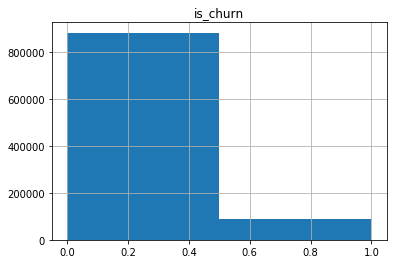

In [7]:
df_train.hist(bins =2)
df_train.is_churn.value_counts()

In [8]:
883630/(883630+87330)

0.9100580868418885

We can see that 91% of users in training dataset is going for renewal. It can lead to bit of bias, let's keep it in mind for further analys. 

### 2.2 Members dataset

Let's merge mebers dataset with train dataset.

In [9]:
train_members = pd.merge(left = df_train,right = df_members,how = 'inner',on=['msno'])
train_members.head()
train_members.info()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5,28,male,3,20131223
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,13,20,male,3,20131223
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,13,18,male,3,20131227
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,1,0,NaN,7,20140109
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,13,35,female,7,20140125


<class 'pandas.core.frame.DataFrame'>
Int64Index: 860967 entries, 0 to 860966
Data columns (total 7 columns):
msno                      860967 non-null object
is_churn                  860967 non-null int64
city                      860967 non-null int64
bd                        860967 non-null int64
gender                    388905 non-null object
registered_via            860967 non-null int64
registration_init_time    860967 non-null int64
dtypes: int64(5), object(2)
memory usage: 52.5+ MB


In [10]:
388905/860967

0.4517072082902132

In [11]:
train_members['gender']=train_members['gender'].fillna("NAN")
train_members.gender.value_counts()
train_members.info()

NAN       472062
male      204561
female    184344
Name: gender, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 860967 entries, 0 to 860966
Data columns (total 7 columns):
msno                      860967 non-null object
is_churn                  860967 non-null int64
city                      860967 non-null int64
bd                        860967 non-null int64
gender                    860967 non-null object
registered_via            860967 non-null int64
registration_init_time    860967 non-null int64
dtypes: int64(5), object(2)
memory usage: 52.5+ MB


55% of gender data are missing.
There is slightly more man than woman.

**Changing the format of dates to YYYY-MM-DD**

In [12]:
train_members['registration_init_time'] = train_members.registration_init_time.apply(
    lambda x: datetime.strptime(str(int(x)), "%Y%m%d").date() if pd.notnull(x) else "NAN")

##### 2.2.1 Members ['city']

Text(0,0.5,'Count')

Text(0.5,0,'City')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]), <a list of 21 Text xticklabel objects>)

Text(0.5,1,'Frequency of City Count in train_members Data Set')

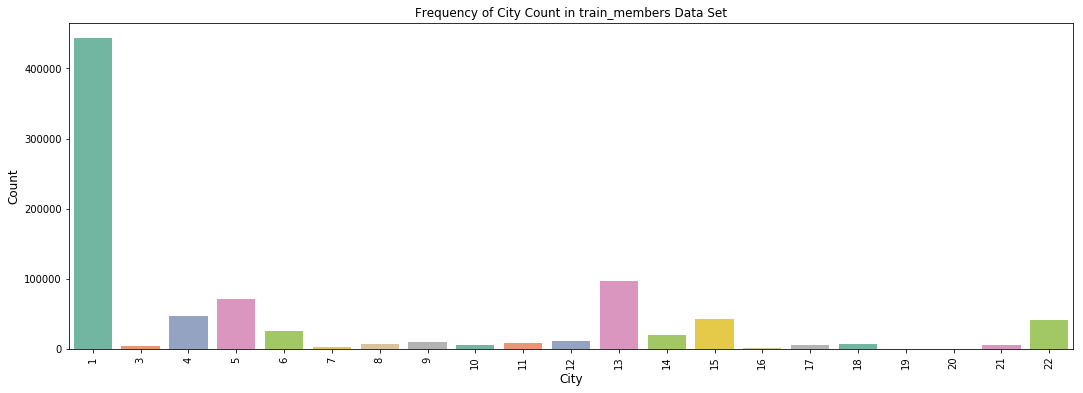

In [13]:
plt.figure(figsize=(18,6))
sns.countplot(x="city", data=train_members, palette="Set2")
plt.ylabel('Count', fontsize=12)
plt.xlabel('City', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of City Count in train_members Data Set", fontsize=12)
plt.show()

We can clearly see that majority of users are from city 1. We can think on possible assumption that the city 1 is capital while rest of the cities are smaller ones.

**Churn distribution per city**

is_churn,0,1,0_%,1_%
city,,,,
21,4434,765,85.29,14.71
12,9798,1585,86.08,13.92
8,6568,1021,86.55,13.45
3,4385,672,86.71,13.29
10,5612,858,86.74,13.26
5,61373,9333,86.80,13.20
4,41133,6094,87.10,12.90
6,22708,3358,87.12,12.88
15,37649,5538,87.18,12.82


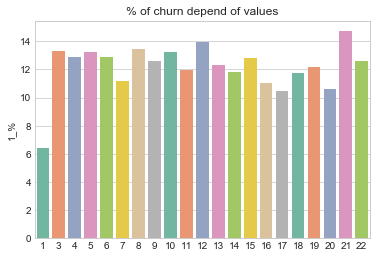

In [14]:
city_crosstab=pd.crosstab(train_members['city'],train_members['is_churn'])
city_crosstab["0_%"] =  round(city_crosstab[0]/(city_crosstab[1]+city_crosstab[0])*100, 2)
city_crosstab["1_%"] =  round(city_crosstab[1]/(city_crosstab[1]+city_crosstab[0])*100, 2)
city_crosstab.sort_values('1_%', ascending = False)

sns.set_style("whitegrid")
ax = sns.barplot(x = city_crosstab.index.values, y = "1_%", data=city_crosstab, palette="Set2").set_title("% of churn depend of values")

In feature engineering we can consider creation of new column with split for 2 clusters: capital and other cities.

##### 2.2.2 Members ['bd'] - AGE

Text(0,0.5,'Count')

Text(0.5,0,'Age')

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

Text(0.5,1,'Frequency of City Count in train_members Data Set')

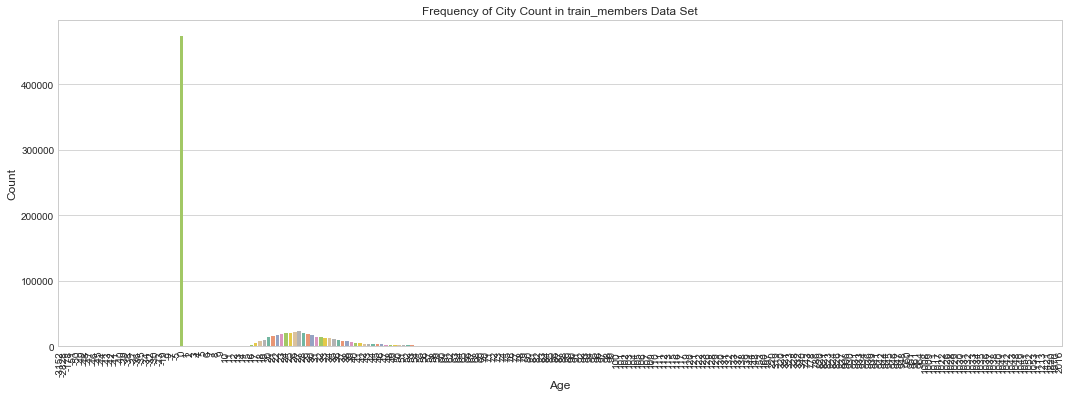

In [15]:
plt.figure(figsize=(18,6))
sns.countplot(x="bd", data=train_members, palette="Set2")
plt.ylabel('Count', fontsize=12)
plt.xlabel('Age', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of City Count in train_members Data Set", fontsize=12)
plt.show()

In [16]:
train_members.bd.value_counts()

 0       473729
 27       22786
 26       21829
 25       20651
 24       20296
 28       20244
 29       19533
 23       19238
 22       18035
 30       17175
 21       15633
 31       15123
 32       14406
 20       13678
 33       13229
 34       12154
 35       10959
 36        9985
 19        9861
 37        8858
 18        8207
 38        7679
 39        6651
 17        5913
 40        5663
 41        5221
 42        4305
 43        3723
 44        3266
 46        3015
 45        3010
 47        2889
 16        2544
 48        2539
 49        2320
 50        2027
 51        1970
 52        1748
 53        1445
 54        1159
 55        1021
 15         848
 56         844
 57         736
 58         541
 59         510
 60         455
 61         390
 62         309
 14         282
 63         258
 64         193
 65         171
 66         147
 67         140
 68          90
 106         81
 69          67
 117         65
 13          63
 70          57
 112         52
 72     

We can see that there are many of unreal data like negative age and very high age. We can see as well that a lot of members have 0 as age. Let's clear this to get better insights and more valuable data.

In [17]:
train_members['bd'] = train_members.bd.apply(lambda x: 0 if x<0 else x )
train_members['bd'] = train_members.bd.apply(lambda x: 101 if x>100 else x )

Text(0,0.5,'Age')

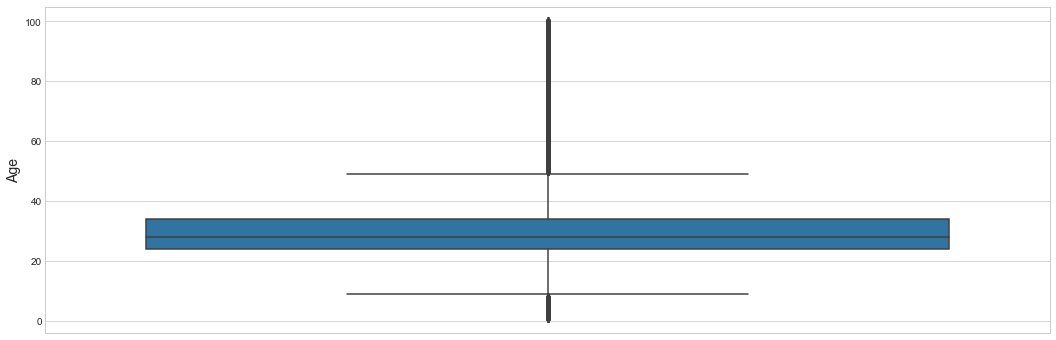

count    386715.000000
mean         29.904216
std           8.920391
min           1.000000
25%          24.000000
50%          28.000000
75%          34.000000
max         100.000000
Name: bd, dtype: float64

Text(0,0.5,'Count')

Text(0.5,0,'Age')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 <a list of 100 Text xticklabel objects>)

Text(0.5,1,'Frequency of City Count in train_members Data Set')

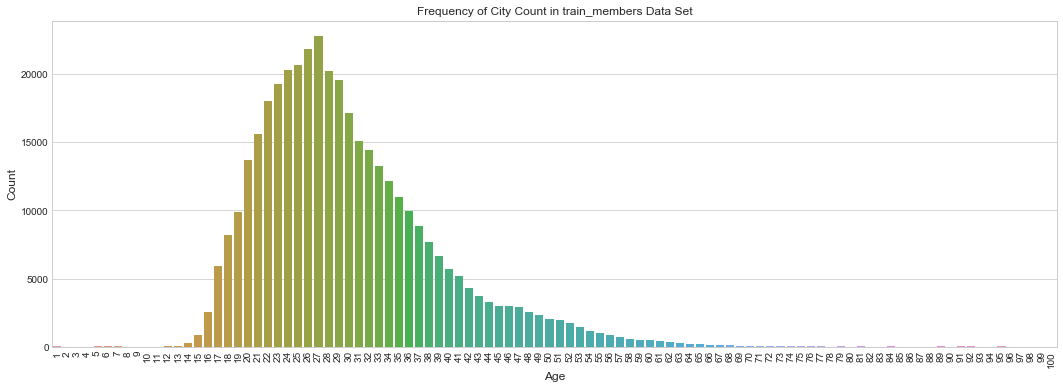

In [18]:
tmp_bd = train_members[(train_members.bd != 0) & (train_members.bd != 101)]
plt.figure(figsize=(18,6))
plt.rcParams['figure.figsize']=(20,10)
sns.boxplot(y="bd", data=tmp_bd);
plt.ylabel('Age', fontsize=14);
plt.show()

tmp_bd.bd.describe()

plt.figure(figsize=(18,6))
sns.countplot(x="bd", data=tmp_bd)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Age', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of City Count in train_members Data Set", fontsize=12)
plt.show()

After cleaning the data we see that majority of real data are from range of 24-34.
<br>Average age is ~29.

**Churn distribution per age**

is_churn,0,1,0_%,1_%
bd,,,,
99,1,1,50.00,50.00
14,166,116,58.87,41.13
13,41,22,65.08,34.92
15,581,267,68.51,31.49
4,7,3,70.00,30.00
16,1809,735,71.11,28.89
17,4330,1583,73.23,26.77
18,6076,2131,74.03,25.97
19,7535,2326,76.41,23.59


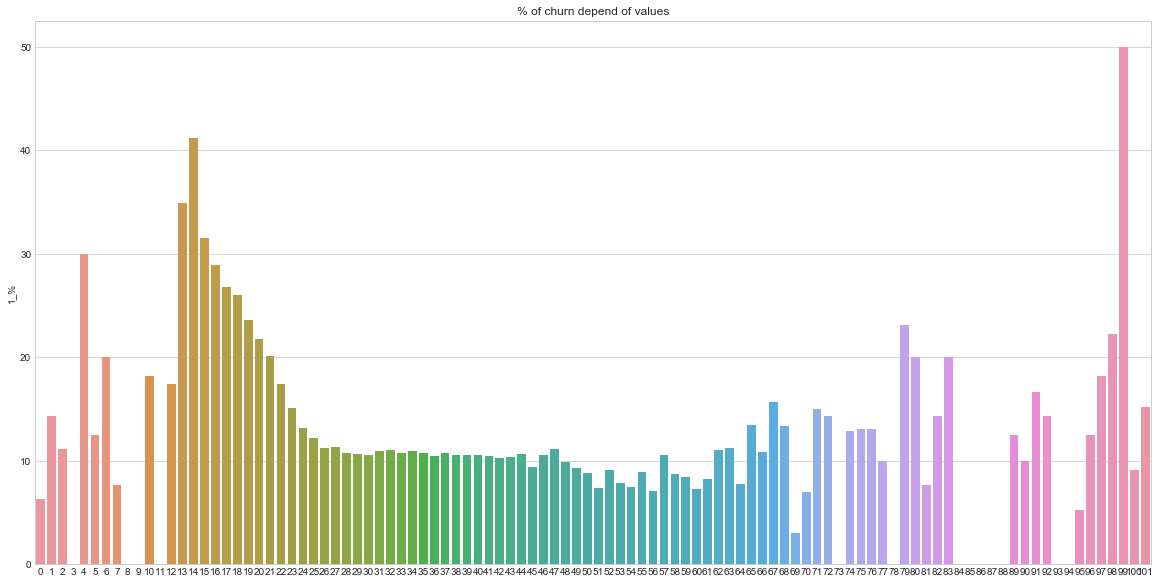

In [19]:
bd_crosstab=pd.crosstab(train_members['bd'],train_members['is_churn'])
bd_crosstab["0_%"] =  round(bd_crosstab[0]/(bd_crosstab[1]+bd_crosstab[0])*100, 2)
bd_crosstab["1_%"] =  round(bd_crosstab[1]/(bd_crosstab[1]+bd_crosstab[0])*100, 2)
bd_crosstab.sort_values('1_%', ascending = False)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize']=(20,10)
ax = sns.barplot(x = bd_crosstab.index.values, y = "1_%", data=bd_crosstab).set_title("% of churn depend of values")

We can clearly see that young people and teens(13-25) tend to churn more often which confirm one of my initial hypothesis. I would split for category teen/young and others in FE(Feature engineering) and consider to separate in other category outliers with fake age information.

##### 2.2.3 Members ['gender']

is_churn,0,1,0_%,1_%
gender,,,,
female,160404,23940,87.01,12.99
male,178165,26396,87.10,12.90
NAN,440950,31112,93.41,6.59


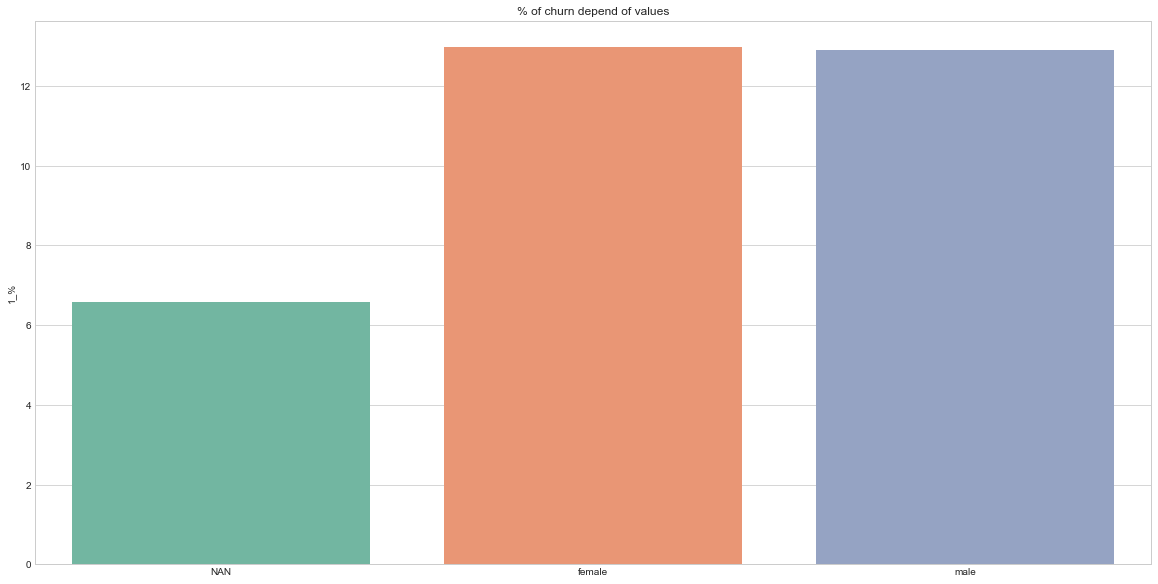

In [20]:
gender_crosstab=pd.crosstab(train_members['gender'],train_members['is_churn'])
gender_crosstab["0_%"] =  round(gender_crosstab[0]/(gender_crosstab[1]+gender_crosstab[0])*100, 2)
gender_crosstab["1_%"] =  round(gender_crosstab[1]/(gender_crosstab[1]+gender_crosstab[0])*100, 2)
gender_crosstab.sort_values('1_%', ascending = False)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize']=(20,10)
ax = sns.barplot(x = gender_crosstab.index.values, y = "1_%", data=gender_crosstab, palette="Set2").set_title("% of churn depend of values")

In [21]:
train_members['gender_fact'] = pd.factorize(train_members['gender'])[0]
train_members.head()
train_members['gender_fact'].value_counts()


,msno,is_churn,city,bd,gender,registered_via,registration_init_time,gender_fact
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5,28,male,3,2013-12-23,0
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,13,20,male,3,2013-12-23,0
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,13,18,male,3,2013-12-27,0
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,1,0,NAN,7,2014-01-09,1
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,13,35,female,7,2014-01-25,2


1    472062
0    204561
2    184344
Name: gender_fact, dtype: int64

Distribution is almost equal for man and woman + we have ~45% missing values. In more deep analysis can be consider to try to predict gender of user. We don't consider gender as very informative here.

##### 2.2.4 Members ['registered_via']

Text(0,0.5,'Count')

Text(0.5,0,'registered_via')

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

Text(0.5,1,'Frequency of registered_via in train_members Data Set')

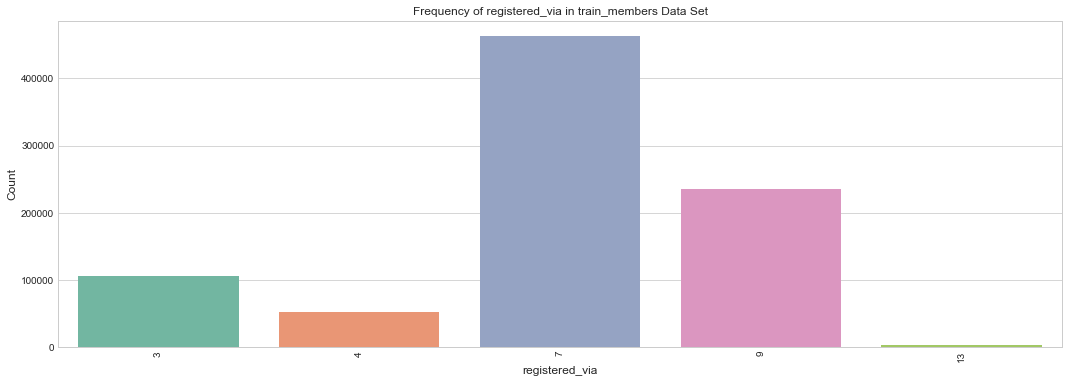

In [22]:
plt.figure(figsize=(18,6))
sns.countplot(x="registered_via", data=train_members, palette="Set2")
plt.ylabel('Count', fontsize=12)
plt.xlabel('registered_via', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of registered_via in train_members Data Set", fontsize=12)
plt.show()

is_churn,0,1,0_%,1_%
registered_via,,,,
4,40559,12185,76.90,23.10
3,88121,18338,82.77,17.23
9,205796,29893,87.32,12.68
13,3056,335,90.12,9.88
7,441987,20697,95.53,4.47


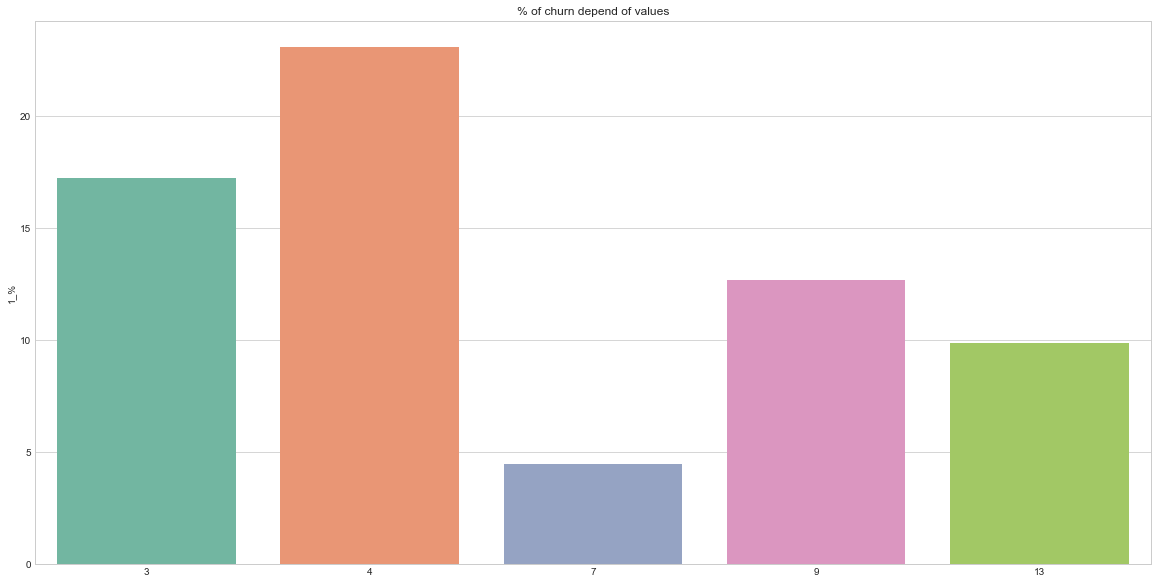

In [23]:
registered_via_crosstab=pd.crosstab(train_members['registered_via'],train_members['is_churn'])
registered_via_crosstab["0_%"] =  round(registered_via_crosstab[0]/(registered_via_crosstab[1]+registered_via_crosstab[0])*100, 2)
registered_via_crosstab["1_%"] =  round(registered_via_crosstab[1]/(registered_via_crosstab[1]+registered_via_crosstab[0])*100, 2)
registered_via_crosstab.sort_values('1_%', ascending = False)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize']=(20,10)
ax = sns.barplot(x = registered_via_crosstab.index.values, y = "1_%", data=registered_via_crosstab, palette="Set2").set_title("% of churn depend of values")

Majority users in given dataset register using method 7, which have as well lowest churn rate. We can consider building new feature with 3 clusters: 7; 9 and 13, 3 and 4.

##### 2.2.5 Members ['registration_init_time'] 

**Creation of 2 new feature containing information about month and weekday**

In [24]:
#train_members['registration_init_time_weekday_cat'] = pd.DatetimeIndex(train_members['registration_init_time']).weekday_name
train_members['registration_init_time_weekday'] = pd.DatetimeIndex(train_members['registration_init_time']).weekday
train_members['registration_init_time_month'] = pd.DatetimeIndex(train_members['registration_init_time']).month

In [25]:
train_members.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time,gender_fact,registration_init_time_weekday,registration_init_time_month
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5,28,male,3,2013-12-23,0,0,12
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,13,20,male,3,2013-12-23,0,0,12
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,13,18,male,3,2013-12-27,0,4,12
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,1,0,NAN,7,2014-01-09,1,3,1
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,13,35,female,7,2014-01-25,2,5,1


Text(0,0.5,'Count')

Text(0.5,0,'registration_init_time_month')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

Text(0.5,1,'Frequency of registration_init_time_month in train_members Data Set')

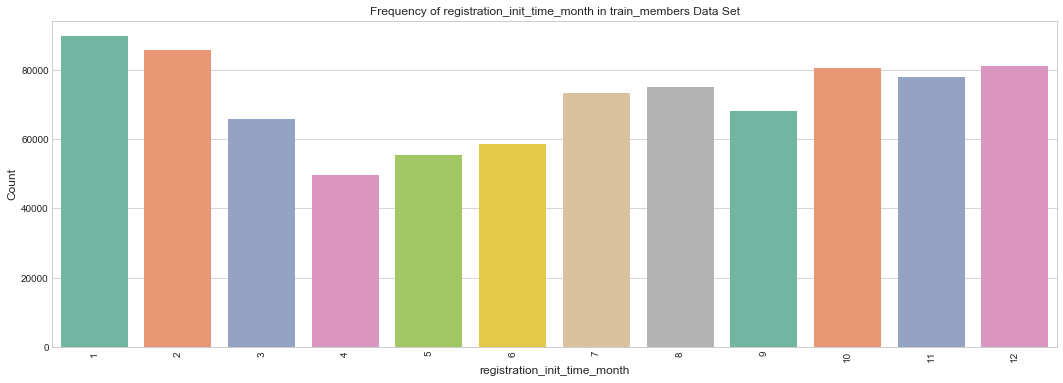

In [26]:
plt.figure(figsize=(18,6))
sns.countplot(x="registration_init_time_month", data=train_members, palette="Set2")
plt.ylabel('Count', fontsize=12)
plt.xlabel('registration_init_time_month', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of registration_init_time_month in train_members Data Set", fontsize=12)
plt.show()

is_churn,0,1,0_%,1_%
registration_init_time_month,,,,
3,58027,7911,88.00,12.00
2,76593,9035,89.45,10.55
1,80691,8949,90.02,9.98
9,61383,6602,90.29,9.71
4,45004,4728,90.49,9.51
6,53218,5364,90.84,9.16
5,50419,5025,90.94,9.06
12,73885,7345,90.96,9.04
10,73268,7260,90.98,9.02


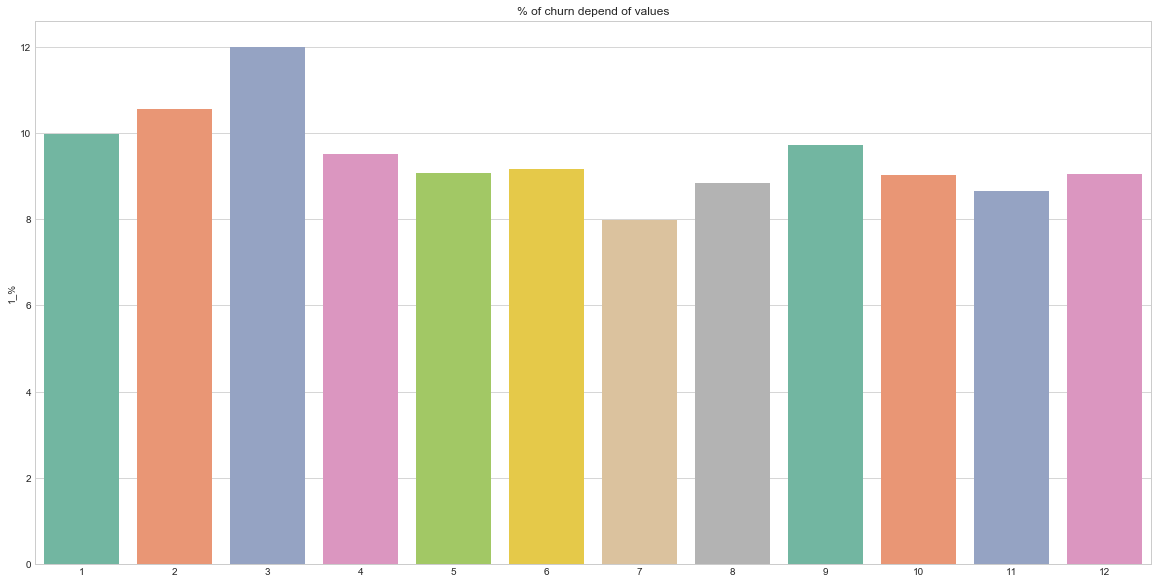

In [27]:
month_crosstab=pd.crosstab(train_members['registration_init_time_month'],train_members['is_churn'])
month_crosstab["0_%"] =  round(month_crosstab[0]/(month_crosstab[1]+month_crosstab[0])*100, 2)
month_crosstab["1_%"] =  round(month_crosstab[1]/(month_crosstab[1]+month_crosstab[0])*100, 2)
month_crosstab.sort_values('1_%', ascending = False)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize']=(20,10)
ax = sns.barplot(x = month_crosstab.index.values, y = "1_%", data=month_crosstab, palette="Set2").set_title("% of churn depend of values")

More users tend to churn at the first quarter of the year. Seasons split can be consider but there is no visible tendency besides already desribed one.

Text(0,0.5,'Count')

Text(0.5,0,'registration_init_time_weekday')

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

Text(0.5,1,'Frequency of registration_init_time_weekday in train_members Data Set')

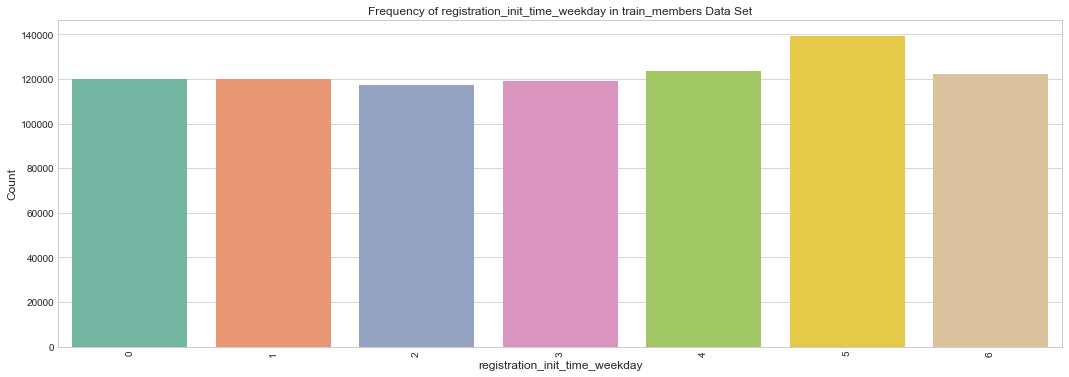

In [28]:
plt.figure(figsize=(18,6))
sns.countplot(x="registration_init_time_weekday", data=train_members, palette="Set2")
plt.ylabel('Count', fontsize=12)
plt.xlabel('registration_init_time_weekday', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of registration_init_time_weekday in train_members Data Set", fontsize=12)
plt.show()

is_churn,0,1,0_%,1_%
registration_init_time_weekday,,,,
6,109904,12283,89.95,10.05
4,111931,11707,90.53,9.47
2,106259,11057,90.58,9.42
3,107685,11196,90.58,9.42
0,108717,11176,90.68,9.32
5,126299,12969,90.69,9.31
1,108724,11060,90.77,9.23


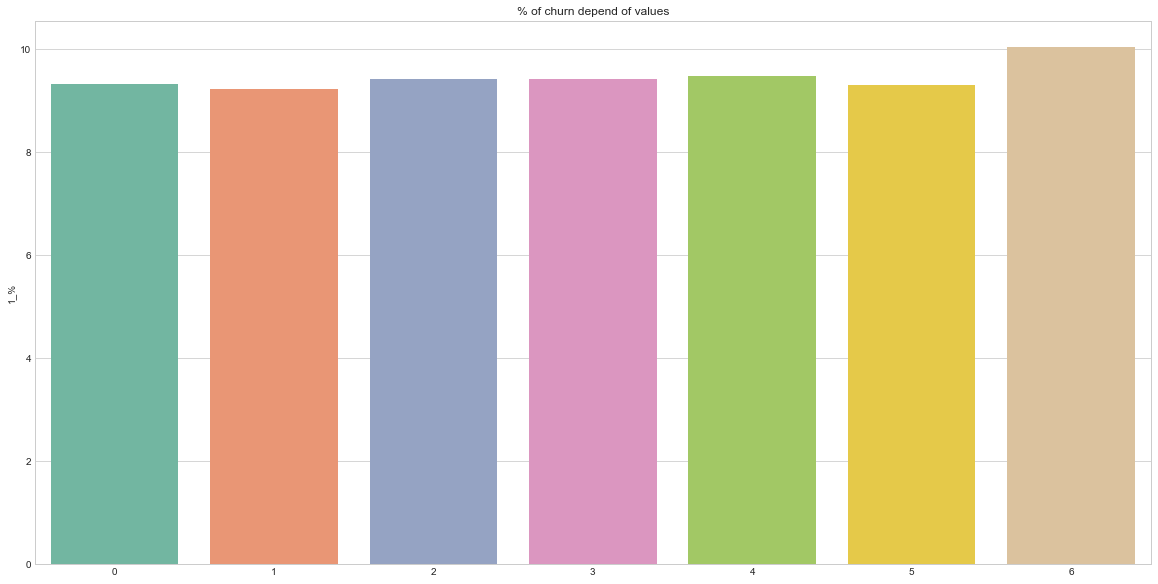

In [29]:
week_crosstab=pd.crosstab(train_members['registration_init_time_weekday'],train_members['is_churn'])
week_crosstab["0_%"] =  round(week_crosstab[0]/(week_crosstab[1]+week_crosstab[0])*100, 2)
week_crosstab["1_%"] =  round(week_crosstab[1]/(week_crosstab[1]+week_crosstab[0])*100, 2)
week_crosstab.sort_values('1_%', ascending = False)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize']=(20,10)
ax = sns.barplot(x = week_crosstab.index.values, y = "1_%", data=week_crosstab, palette="Set2").set_title("% of churn depend of values")

Distribution of churn per weekday is almost flat. This feature is not consider as very informative.

====================================================================================================
### 2.3 Transaction dataset

In [30]:
train_trans = pd.merge(left = df_train,right = df_transaction,how = 'inner',on=['msno'])
train_trans.head()
train_trans.info()

,msno,is_churn,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,36,30,180,180,0,20170311,20170411,0
1,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,17,60,0,0,0,20170311,20170314,0
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,15,90,300,300,0,20170314,20170615,0
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,41,30,149,149,1,20150908,20170608,0
4,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,41,30,149,149,1,20150908,20170708,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1132036 entries, 0 to 1132035
Data columns (total 10 columns):
msno                      1132036 non-null object
is_churn                  1132036 non-null int64
payment_method_id         1132036 non-null int64
payment_plan_days         1132036 non-null int64
plan_list_price           1132036 non-null int64
actual_amount_paid        1132036 non-null int64
is_auto_renew             1132036 non-null int64
transaction_date          1132036 non-null int64
membership_expire_date    1132036 non-null int64
is_cancel                 1132036 non-null int64
dtypes: int64(9), object(1)
memory usage: 95.0+ MB


**Changing the format of the dates**

In [31]:
train_trans['transaction_date'] = train_trans.transaction_date.apply(
    lambda x: datetime.strptime(str(int(x)), "%Y%m%d").date() if pd.notnull(x) else "NAN" )
train_trans['membership_expire_date'] = train_trans.membership_expire_date.apply(
    lambda x: datetime.strptime(str(int(x)), "%Y%m%d").date() if pd.notnull(x) else "NAN")

In [32]:
train_trans.msno.unique().shape, train_trans.msno.shape

((933578,), (1132036,))

##### 2.3.1 Transactions['payment_method_id'] 

Text(0,0.5,'Count')

Text(0.5,0,'payment_method_id')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 <a list of 33 Text xticklabel objects>)

Text(0.5,1,'Frequency of payment_method_id in train_members Data Set')

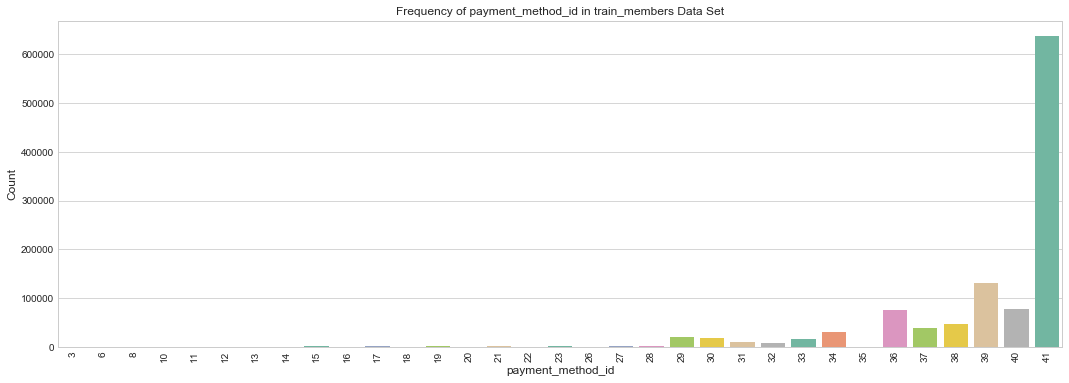

41    636230
39    131672
40     77817
36     76543
38     47420
37     38224
34     30088
29     19501
30     18017
33     15961
31     11034
32      8609
15      3001
23      2612
17      2283
19      2116
27      1929
21      1846
28      1792
16       918
20       859
35       807
18       672
14       666
22       488
13       307
12       267
26       214
11        79
10        40
8         10
3          9
6          5
Name: payment_method_id, dtype: int64

In [33]:
plt.figure(figsize=(18,6))
sns.countplot(x="payment_method_id", data=train_trans, palette="Set2")
plt.ylabel('Count', fontsize=12)
plt.xlabel('payment_method_id', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of payment_method_id in train_members Data Set", fontsize=12)
plt.show()

train_trans.payment_method_id.value_counts()

In [34]:
636230/1132036

0.5620227625269868

is_churn,0,1,0_%,1_%
payment_method_id,,,,
3,0,9,0.00,100.00
6,0,5,0.00,100.00
13,1,306,0.33,99.67
22,2,486,0.41,99.59
20,5,854,0.58,99.42
32,309,8300,3.59,96.41
12,13,254,4.87,95.13
17,224,2059,9.81,90.19
8,1,9,10.00,90.00


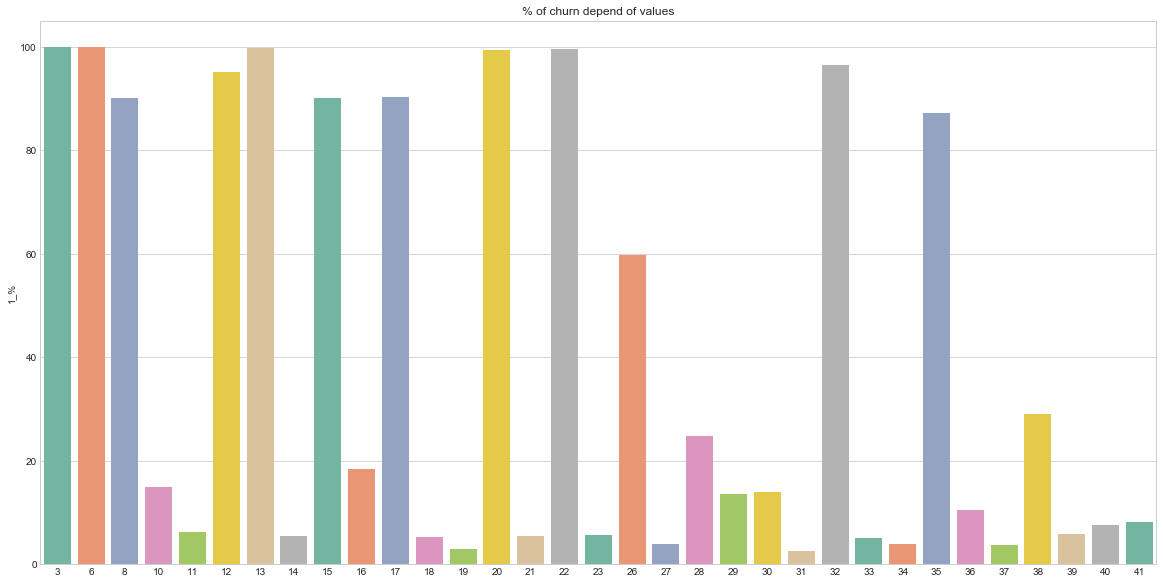

In [35]:
pay_met_id_crosstab=pd.crosstab(train_trans['payment_method_id'],train_trans['is_churn'])
pay_met_id_crosstab["0_%"] =  round(pay_met_id_crosstab[0]/(pay_met_id_crosstab[1]+pay_met_id_crosstab[0])*100, 2)
pay_met_id_crosstab["1_%"] =  round(pay_met_id_crosstab[1]/(pay_met_id_crosstab[1]+pay_met_id_crosstab[0])*100, 2)
pay_met_id_crosstab = pay_met_id_crosstab.sort_values('1_%', ascending = False)
pay_met_id_crosstab

sns.set_style("whitegrid")
plt.rcParams['figure.figsize']=(20,10)
ax = sns.barplot(x = pay_met_id_crosstab.index.values, y = "1_%", data=pay_met_id_crosstab, palette="Set2").set_title("% of churn depend of values")

56% of users used payment method 41. There are visible clusterings, as I suspect there is some co-dependecy, let's check what other links we can find in methoda with similar churn rate.

In [36]:
#train_trans.loc[train_trans['payment_method_id'] == 13]
#train_trans.loc[train_trans['payment_method_id'] == 20]
#train_trans.loc[train_trans['payment_method_id'] == 12]

So as we can clearly see there all have *'is_auto_renew'* = 0. Let's now check payment methods with low churn rate.

In [37]:
#train_trans.loc[train_trans['payment_method_id'] == 31]
#train_trans.loc[train_trans['payment_method_id'] == 19]
#train_trans.loc[train_trans['payment_method_id'] == 37]

Majority of *'is_auto_renew'* are equal 1. Let's explore further this dependencie to create new feature based on that.

In [38]:
pay_met_auto_crosstab=pd.crosstab(train_trans['payment_method_id'],train_trans['is_auto_renew'])
pay_met_auto_crosstab["is_auto_0"] =  round(pay_met_auto_crosstab[0]/(pay_met_auto_crosstab[1]+pay_met_auto_crosstab[0])*100, 2)
pay_met_auto_crosstab["is_auto_1"] =  round(pay_met_auto_crosstab[1]/(pay_met_auto_crosstab[1]+pay_met_auto_crosstab[0])*100, 2)
pay_met_auto_crosstab.sort_values('is_auto_0', ascending = False)
pay_met_auto_crosstab.shape

is_auto_renew,0,1,is_auto_0,is_auto_1
payment_method_id,,,,
3,9,0,100.00,0.00
26,214,0,100.00,0.00
22,488,0,100.00,0.00
35,807,0,100.00,0.00
20,859,0,100.00,0.00
32,8609,0,100.00,0.00
17,2283,0,100.00,0.00
15,3001,0,100.00,0.00
38,47420,0,100.00,0.00


(33, 4)

In [39]:
pay_met_temp = pd.merge(pay_met_id_crosstab, pay_met_auto_crosstab, left_index=True, right_index=True)
pay_met_temp.sort_values('is_auto_0', ascending = False)

pay_met_temp.shape

,0_x,1_x,0_%,1_%,0_y,1_y,is_auto_0,is_auto_1
payment_method_id,,,,,,,,
3,0,9,0.00,100.00,9,0,100.00,0.00
17,224,2059,9.81,90.19,2283,0,100.00,0.00
28,1348,444,75.22,24.78,1792,0,100.00,0.00
38,33632,13788,70.92,29.08,47420,0,100.00,0.00
26,86,128,40.19,59.81,214,0,100.00,0.00
35,104,703,12.89,87.11,807,0,100.00,0.00
15,300,2701,10.00,90.00,3001,0,100.00,0.00
8,1,9,10.00,90.00,10,0,100.00,0.00
12,13,254,4.87,95.13,267,0,100.00,0.00


(33, 8)

So we confirmed dependency, on FE we will create then new variable with 2 categories:
1. payment method with high churn rate and no auto renew
2. other data

##### 2.3.2 Transactions['payment_plan_days'] 

Text(0,0.5,'Count')

Text(0.5,0,'payment_plan_days')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

Text(0.5,1,'Frequency of payment_plan_days in train_members Data Set')

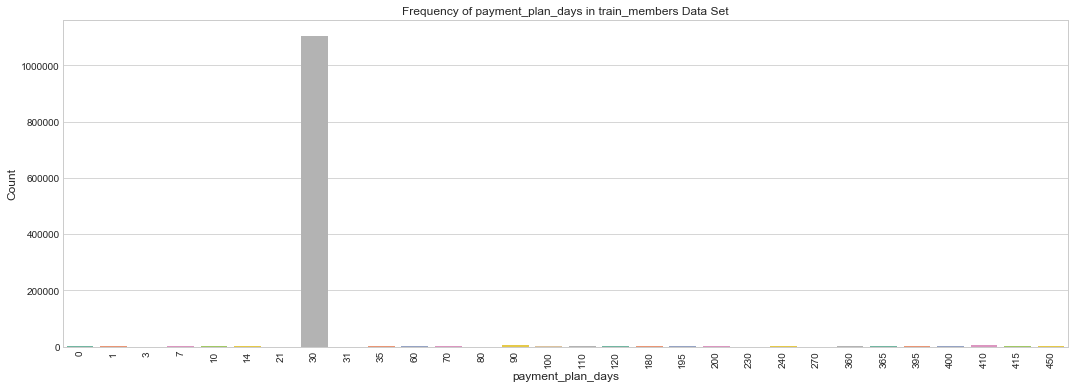

In [40]:
plt.figure(figsize=(18,6))
sns.countplot(x="payment_plan_days", data=train_trans, palette="Set2")
plt.ylabel('Count', fontsize=12)
plt.xlabel('payment_plan_days', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of payment_plan_days in train_members Data Set", fontsize=12)
plt.show()

is_churn,0,1,0_%,1_%
payment_plan_days,,,,
110,0,12,0.00,100.00
31,0,3,0.00,100.00
400,0,153,0.00,100.00
395,0,293,0.00,100.00
270,0,9,0.00,100.00
230,0,2,0.00,100.00
80,0,10,0.00,100.00
35,0,22,0.00,100.00
450,0,78,0.00,100.00


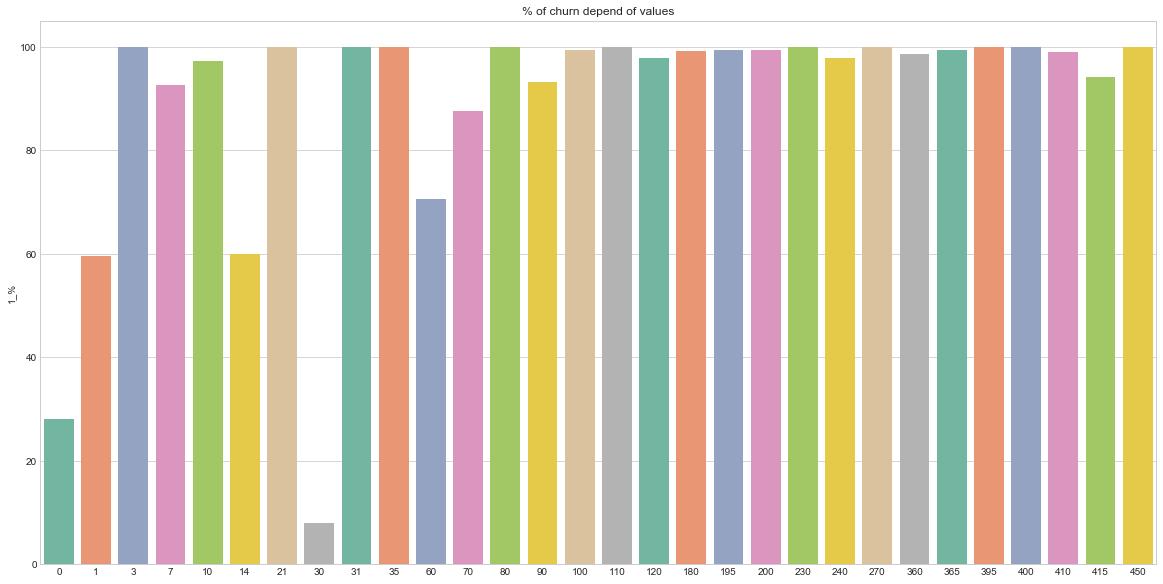

In [41]:
pay_plan_crosstab=pd.crosstab(train_trans['payment_plan_days'],train_trans['is_churn'])
pay_plan_crosstab["0_%"] =  round(pay_plan_crosstab[0]/(pay_plan_crosstab[1]+pay_plan_crosstab[0])*100, 2)
pay_plan_crosstab["1_%"] =  round(pay_plan_crosstab[1]/(pay_plan_crosstab[1]+pay_plan_crosstab[0])*100, 2)
pay_plan_crosstab.sort_values('1_%', ascending = False)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize']=(20,10)
ax = sns.barplot(x = pay_plan_crosstab.index.values, y = "1_%", data=pay_plan_crosstab, palette="Set2").set_title("% of churn depend of values")

As we can see most of the users chosen 30 days plan which make sense, as monthly subscription is common, for those users churn rate is the lowest.
In FE I would create new feature based on this information with 5 clusters:
1. 30 days plan
2. plan with churn rate = 100%
3. plan with churn rate in range <87%, 100%)
4. plan with churn rate in range < 70%, 50% > 
5. 0 days plan

##### 2.3.3 Transactions['plan_list_price'] 

Text(0,0.5,'Count')

Text(0.5,0,'plan_list_price')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42]),
 <a list of 43 Text xticklabel objects>)

Text(0.5,1,'Frequency of plan_list_price in train_members Data Set')

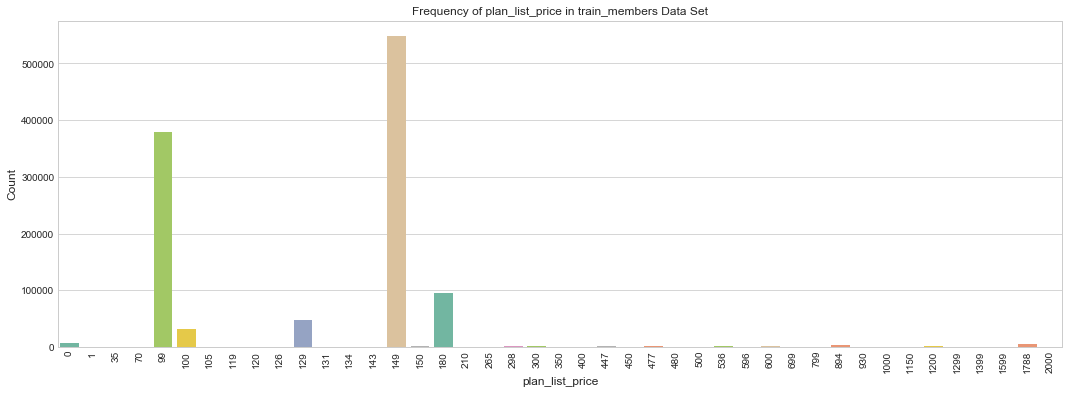

In [42]:
plt.figure(figsize=(18,6))
sns.countplot(x="plan_list_price", data=train_trans, palette="Set2")
plt.ylabel('Count', fontsize=12)
plt.xlabel('plan_list_price', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of plan_list_price in train_members Data Set", fontsize=12)
plt.show()

is_churn,0,1,0_%,1_%
plan_list_price,,,,
2000,0,6,0.00,100.00
126,0,46,0.00,100.00
400,0,10,0.00,100.00
1,0,2,0.00,100.00
210,0,65,0.00,100.00
596,0,8,0.00,100.00
699,0,2,0.00,100.00
1000,0,38,0.00,100.00
799,0,95,0.00,100.00


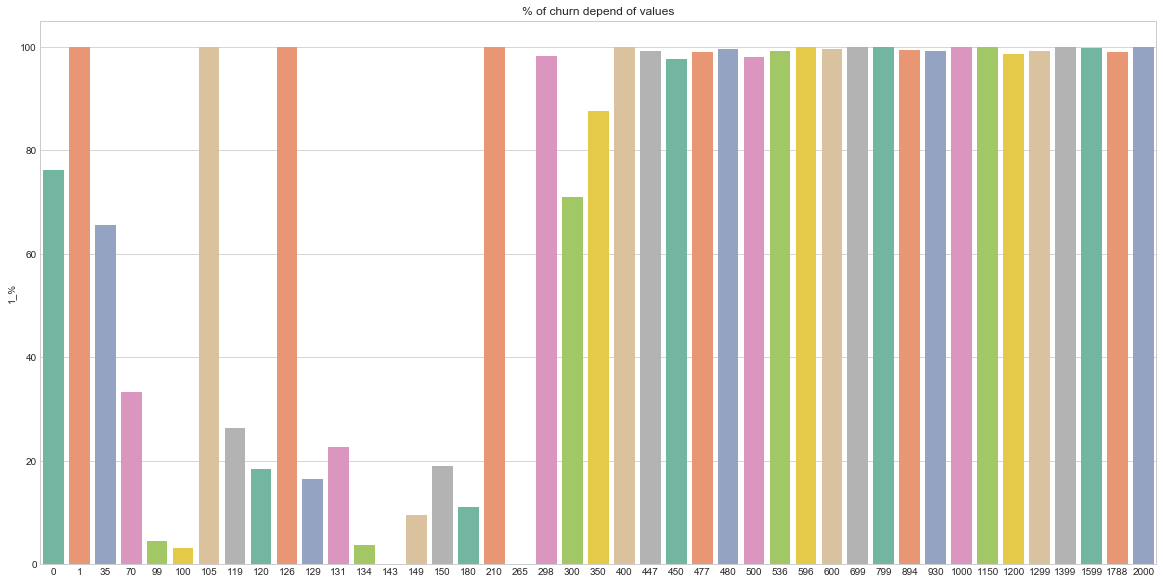

In [43]:
plan_list_price_crosstab=pd.crosstab(train_trans['plan_list_price'],train_trans['is_churn'])
plan_list_price_crosstab["0_%"] =  round(plan_list_price_crosstab[0]/(plan_list_price_crosstab[1]+plan_list_price_crosstab[0])*100, 2)
plan_list_price_crosstab["1_%"] =  round(plan_list_price_crosstab[1]/(plan_list_price_crosstab[1]+plan_list_price_crosstab[0])*100, 2)
plan_list_price_crosstab.sort_values('1_%', ascending = False)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize']=(20,10)
ax = sns.barplot(x = plan_list_price_crosstab.index.values, y = "1_%", data=plan_list_price_crosstab, palette="Set2").set_title("% of churn depend of values")

Let's check correlation with *payment_plan_days* as by common understanding those fetures should be highly dependent

In [44]:
train_trans['payment_plan_days'].corr(train_trans['plan_list_price'])

0.9423019231811397

High correlation between those 2 features is giving me information that it doesn't make sense to use both of them in model, hence I will use only *'payment_plan_days'* with cluster split.

Nevertheless inspired by https://www.kaggle.com/jeru666/did-you-think-of-these-features I will use *'plan_list_price'* to create *'discount'* feature.

In [45]:
train_trans['discount'] = train_trans['plan_list_price'] - train_trans['actual_amount_paid']
train_trans['discount'].unique()

array([   0,  149,  180, -149,   30, -119, -129,  120,   20,   50, -100,
         -1,   99,  129,    1, 1599], dtype=int64)

is_churn,0,1,0_%,1_%
discount,,,,
-1,0,46,0.00,100.00
120,0,10,0.00,100.00
149,221,763,22.46,77.54
129,2,2,50.00,50.00
180,1955,1169,62.58,37.42
-149,1054,434,70.83,29.17
-119,205,80,71.93,28.07
30,2220,865,71.96,28.04
-129,104,22,82.54,17.46


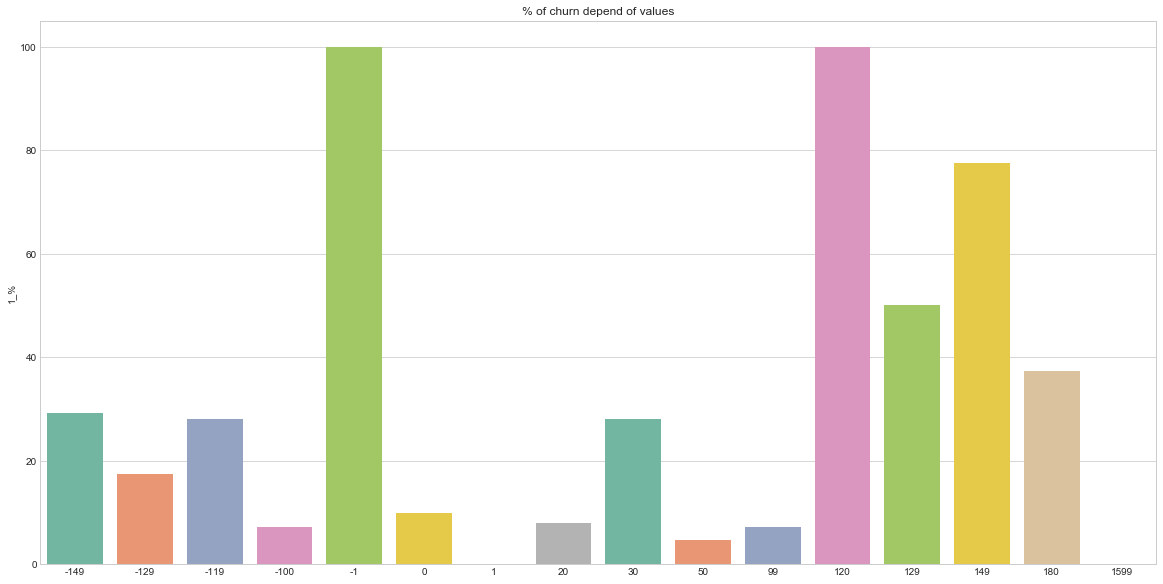

In [46]:
discount_crosstab=pd.crosstab(train_trans['discount'],train_trans['is_churn'])
discount_crosstab["0_%"] =  round(discount_crosstab[0]/(discount_crosstab[1]+discount_crosstab[0])*100, 2)
discount_crosstab["1_%"] =  round(discount_crosstab[1]/(discount_crosstab[1]+discount_crosstab[0])*100, 2)
discount_crosstab.sort_values('1_%', ascending = False)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize']=(20,10)
ax = sns.barplot(x = discount_crosstab.index.values, y = "1_%", data=discount_crosstab, palette="Set2").set_title("% of churn depend of values")

Majority of the people didn't got any discount. As distribution of churn rate didn't show strong patterns let's create binary variable *'is discount'*.

In [47]:
train_trans['is_discount'] = train_trans.discount.apply(lambda x: 1 if x>0 else 0)
train_trans['is_discount'].unique()

array([0, 1], dtype=int64)

##### 2.3.4 Transactions['actual_amount_paid'] 

In [48]:
train_trans['payment_plan_days'].corr(train_trans['plan_list_price'])
train_trans['actual_amount_paid'].corr(train_trans['plan_list_price'])

0.9423019231811397

0.9957775305801594

As suspected this feature is highly correlated with already explored *'plan_list_price'* hence will not explore further.

##### 2.3.5 Transactions['is_auto_renew'] 

Text(0,0.5,'Count')

Text(0.5,0,'is_auto_renew')

(array([0, 1]), <a list of 2 Text xticklabel objects>)

Text(0.5,1,'Frequency of payment_method_id in train_members Data Set')

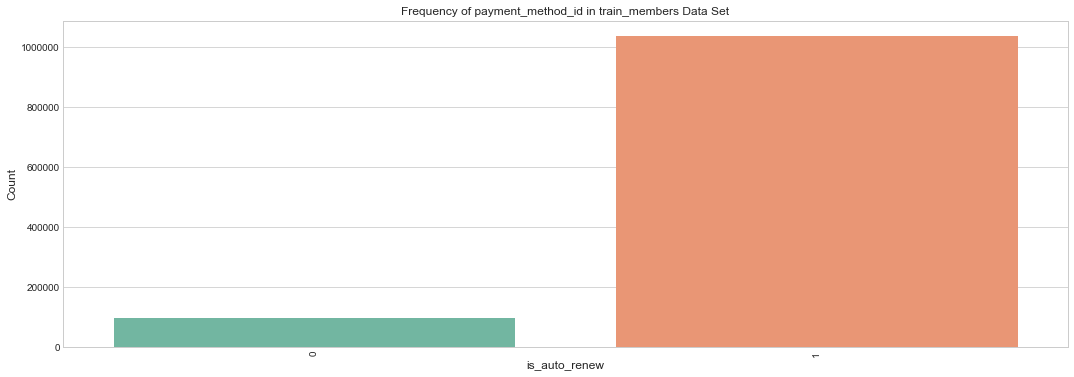

1    1037286
0      94750
Name: is_auto_renew, dtype: int64

In [49]:
plt.figure(figsize=(18,6))
sns.countplot(x="is_auto_renew", data=train_trans, palette="Set2")
plt.ylabel('Count', fontsize=12)
plt.xlabel('is_auto_renew', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of payment_method_id in train_members Data Set", fontsize=12)
plt.show()

train_trans.is_auto_renew.value_counts()

In [50]:
auto_crosstab=pd.crosstab(train_trans['is_auto_renew'],train_trans['is_churn'])
auto_crosstab["0_%"] =  round(auto_crosstab[0]/(auto_crosstab[1]+auto_crosstab[0])*100, 2)
auto_crosstab["1_%"] =  round(auto_crosstab[1]/(auto_crosstab[1]+auto_crosstab[0])*100, 2)
auto_crosstab.sort_values('1_%', ascending = False)

is_churn,0,1,0_%,1_%
is_auto_renew,,,,
0,60576,34174,63.93,36.07
1,957887,79399,92.35,7.65


Not suprisingly we see that clients with automatic renewal less frequently unsubscribe.

##### 2.3.6 Transactions['transaction_date'] 

**Creation of new features with split for month and week**

In [51]:
train_trans['transaction_month'] = pd.DatetimeIndex(train_trans['transaction_date']).month
train_trans['transaction_weekday'] = pd.DatetimeIndex(train_trans['transaction_date']).weekday

Text(0,0.5,'Count')

Text(0.5,0,'transaction_month')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

Text(0.5,1,'Frequency of transaction_month in train_members Data Set')

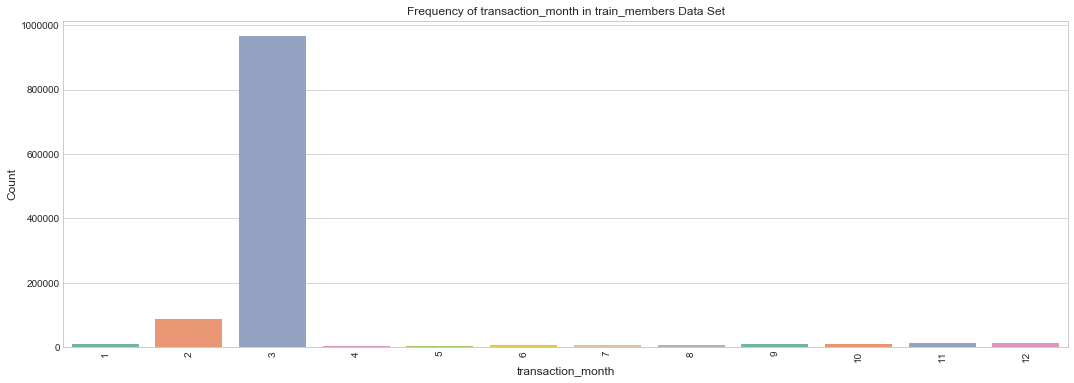

3     964972
2      87810
12     13328
11     12320
10     10022
1       8838
9       8014
8       7352
7       6844
6       5036
5       4186
4       3314
Name: transaction_month, dtype: int64

In [52]:
plt.figure(figsize=(18,6))
sns.countplot(x="transaction_month", data=train_trans, palette="Set2")
plt.ylabel('Count', fontsize=12)
plt.xlabel('transaction_month', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of transaction_month in train_members Data Set", fontsize=12)
plt.show()

train_trans['transaction_month'].value_counts()

In [53]:
964972/1132036 # march data %

0.8524216544350179

is_churn,0,1,0_%,1_%
transaction_month,,,,
1,1700,7138,19.24,80.76
12,7070,6258,53.05,46.95
7,4093,2751,59.80,40.20
10,6351,3671,63.37,36.63
11,7835,4485,63.60,36.40
9,5140,2874,64.14,35.86
8,4721,2631,64.21,35.79
6,3358,1678,66.68,33.32
5,2800,1386,66.89,33.11


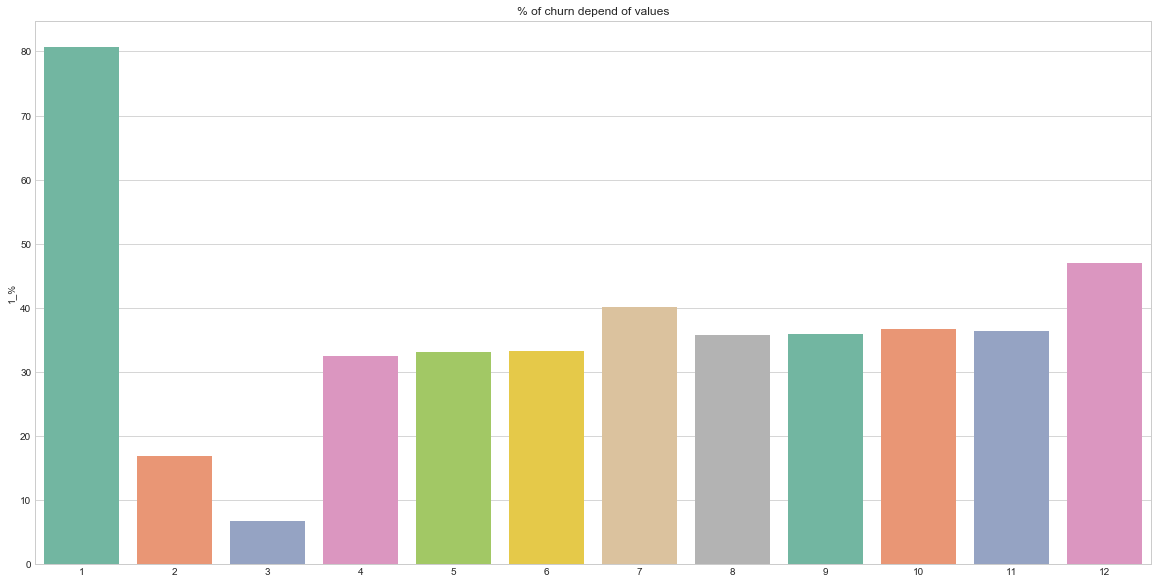

In [54]:
transaction_month_crosstab=pd.crosstab(train_trans['transaction_month'],train_trans['is_churn'])
transaction_month_crosstab["0_%"] =  round(transaction_month_crosstab[0]/(transaction_month_crosstab[1]+transaction_month_crosstab[0])*100, 2)
transaction_month_crosstab["1_%"] =  round(transaction_month_crosstab[1]/(transaction_month_crosstab[1]+transaction_month_crosstab[0])*100, 2)
transaction_month_crosstab.sort_values('1_%', ascending = False)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize']=(20,10)
ax = sns.barplot(x = transaction_month_crosstab.index.values, y = "1_%", data=transaction_month_crosstab, palette="Set2").set_title("% of churn depend of values")

Users tend to churn more often on Jan and Dec, and less often on Feb and March (let's keep in mind that 85% of data are for March). I will create new feature *'transaction_month_cat'* with split for mentioned 2 clusters + remaining months as 3rd cluster.

Text(0,0.5,'Count')

Text(0.5,0,'transaction_weekday')

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

Text(0.5,1,'Frequency of transaction_weekday in train_members Data Set')

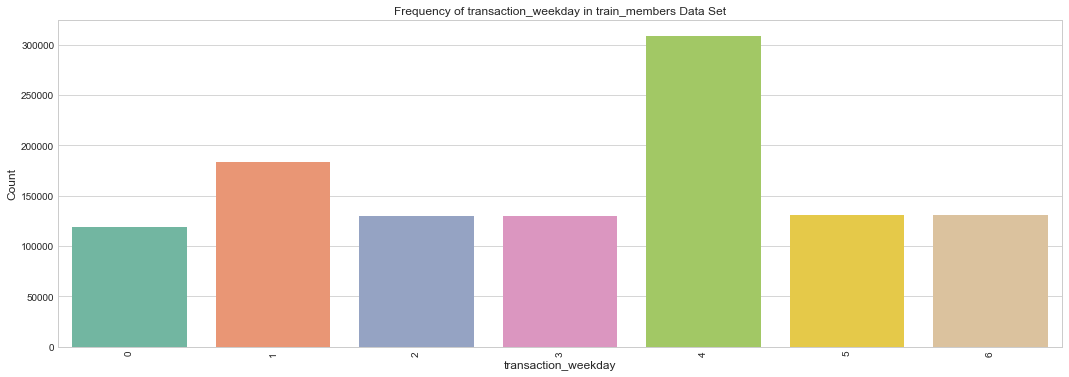

In [55]:
plt.figure(figsize=(18,6))
sns.countplot(x="transaction_weekday", data=train_trans, palette="Set2")
plt.ylabel('Count', fontsize=12)
plt.xlabel('transaction_weekday', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of transaction_weekday in train_members Data Set", fontsize=12)
plt.show()

is_churn,0,1,0_%,1_%
transaction_weekday,,,,
2,111435,18066,86.05,13.95
0,104035,15199,87.25,12.75
3,114989,15192,88.33,11.67
5,115644,14912,88.58,11.42
1,163064,20246,88.96,11.04
6,117448,13183,89.91,10.09
4,291848,16775,94.56,5.44


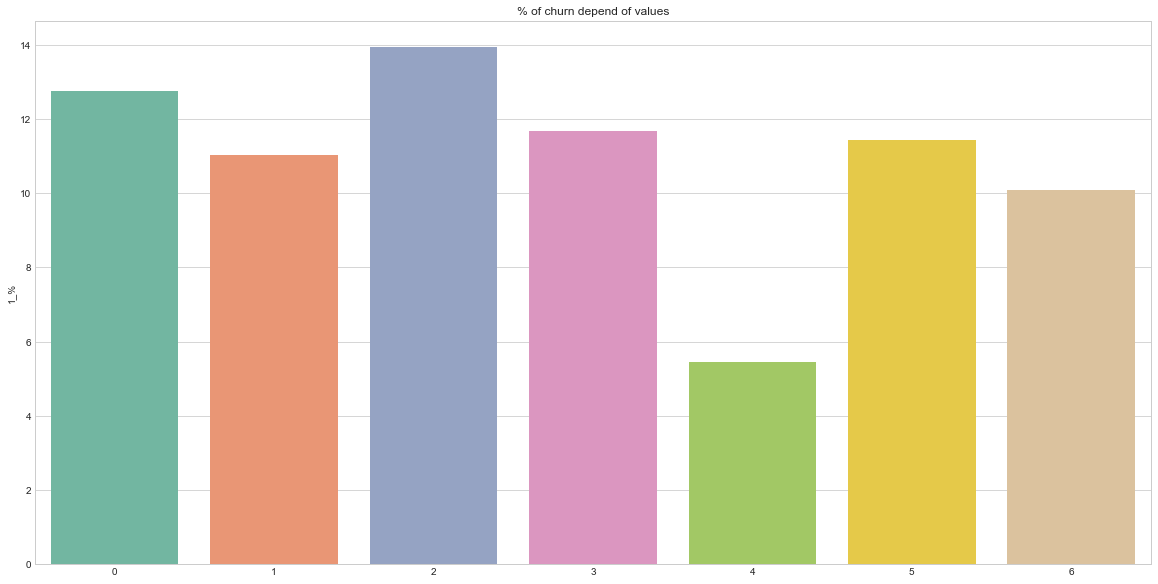

In [56]:
transaction_weekday_crosstab=pd.crosstab(train_trans['transaction_weekday'],train_trans['is_churn'])
transaction_weekday_crosstab["0_%"] =  round(transaction_weekday_crosstab[0]/(transaction_weekday_crosstab[1]+transaction_weekday_crosstab[0])*100, 2)
transaction_weekday_crosstab["1_%"] =  round(transaction_weekday_crosstab[1]/(transaction_weekday_crosstab[1]+transaction_weekday_crosstab[0])*100, 2)
transaction_weekday_crosstab.sort_values('1_%', ascending = False)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize']=(20,10)
ax = sns.barplot(x = transaction_weekday_crosstab.index.values, y = "1_%", data=transaction_weekday_crosstab, palette="Set2").set_title("% of churn depend of values")

Based on given data we can assume that users who made transactions on firday tend to less frequently unsubscribe. I will create binary feature for friday data.

##### 2.3.7 Transactions['membership_expire_date] 

**Creation of new features with split for month and week**

In [57]:
train_trans['membership_expire_month'] = pd.DatetimeIndex(train_trans['membership_expire_date']).month
train_trans['membership_expire_weekday'] = pd.DatetimeIndex(train_trans['membership_expire_date']).weekday

Text(0,0.5,'Count')

Text(0.5,0,'membership_expire_month')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

Text(0.5,1,'Frequency of membership_expire_month in train_members Data Set')

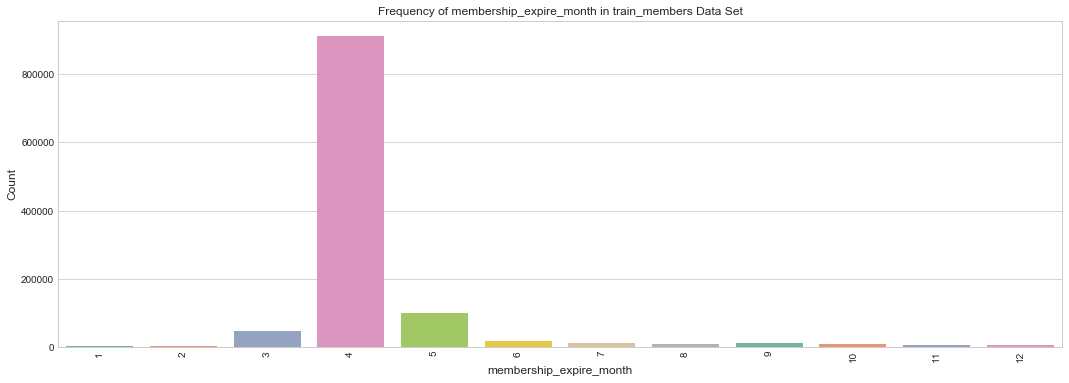

4     911224
5      99891
3      47600
6      17470
9      11145
7      10467
8       8217
10      7622
11      6184
12      4609
1       4180
2       3427
Name: membership_expire_month, dtype: int64

In [58]:
plt.figure(figsize=(18,6))
sns.countplot(x="membership_expire_month", data=train_trans, palette="Set2")
plt.ylabel('Count', fontsize=12)
plt.xlabel('membership_expire_month', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of membership_expire_month in train_members Data Set", fontsize=12)
plt.show()

train_trans['membership_expire_month'].value_counts()

In [59]:
911224/1132036 # percentage of April data

0.8049425989986184

is_churn,0,1,0_%,1_%
membership_expire_month,,,,
6,5801,11669,33.21,66.79
9,3959,7186,35.52,64.48
10,3714,3908,48.73,51.27
7,5104,5363,48.76,51.24
3,24495,23105,51.46,48.54
11,3312,2872,53.56,46.44
8,4514,3703,54.93,45.07
12,2932,1677,63.61,36.39
2,2210,1217,64.49,35.51


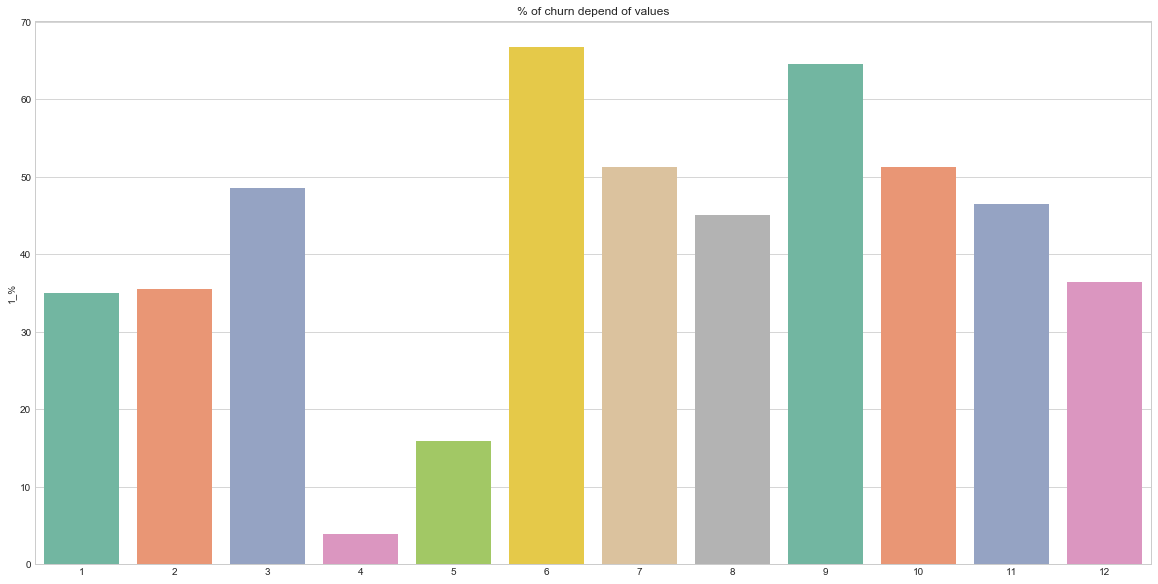

In [60]:
membership_expire_month_crosstab=pd.crosstab(train_trans['membership_expire_month'],train_trans['is_churn'])
membership_expire_month_crosstab["0_%"] =  round(membership_expire_month_crosstab[0]/(membership_expire_month_crosstab[1]+membership_expire_month_crosstab[0])*100, 2)
membership_expire_month_crosstab["1_%"] =  round(membership_expire_month_crosstab[1]/(membership_expire_month_crosstab[1]+membership_expire_month_crosstab[0])*100, 2)
membership_expire_month_crosstab.sort_values('1_%', ascending = False)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize']=(20,10)
ax = sns.barplot(x = membership_expire_month_crosstab.index.values, y = "1_%", data=membership_expire_month_crosstab, palette="Set2").set_title("% of churn depend of values")

I will explore further split months into clusters based on churn rate in FE phase. 

Text(0,0.5,'Count')

Text(0.5,0,'membership_expire_weekday')

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

Text(0.5,1,'Frequency of membership_expire_weekday in train_members Data Set')

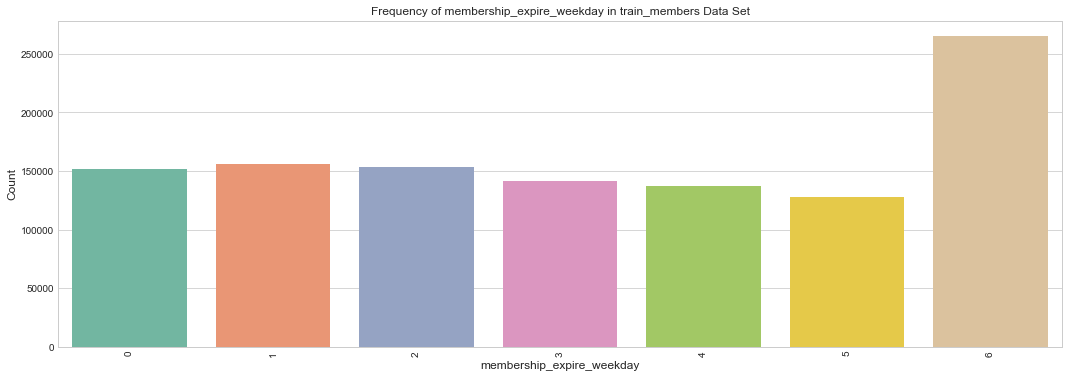

In [61]:
plt.figure(figsize=(18,6))
sns.countplot(x="membership_expire_weekday", data=train_trans, palette="Set2")
plt.ylabel('Count', fontsize=12)
plt.xlabel('membership_expire_weekday', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of membership_expire_weekday in train_members Data Set", fontsize=12)
plt.show()

is_churn,0,1,0_%,1_%
membership_expire_weekday,,,,
4,119879,17127,87.50,12.50
5,111869,15781,87.64,12.36
2,135960,17815,88.41,11.59
3,125286,16045,88.65,11.35
0,135802,15638,89.67,10.33
1,140118,15495,90.04,9.96
6,249549,15672,94.09,5.91


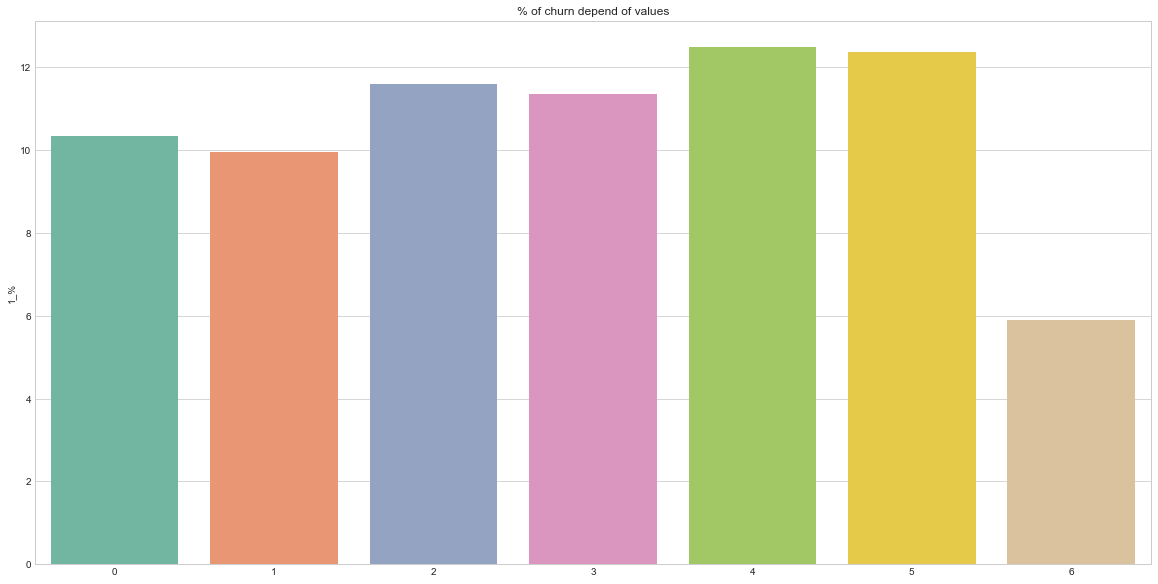

In [62]:
membership_expire_weekday_crosstab=pd.crosstab(train_trans['membership_expire_weekday'],train_trans['is_churn'])
membership_expire_weekday_crosstab["0_%"] =  round(membership_expire_weekday_crosstab[0]/(membership_expire_weekday_crosstab[1]+membership_expire_weekday_crosstab[0])*100, 2)
membership_expire_weekday_crosstab["1_%"] =  round(membership_expire_weekday_crosstab[1]/(membership_expire_weekday_crosstab[1]+membership_expire_weekday_crosstab[0])*100, 2)
membership_expire_weekday_crosstab.sort_values('1_%', ascending = False)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize']=(20,10)
ax = sns.barplot(x = membership_expire_weekday_crosstab.index.values, y = "1_%", data=membership_expire_weekday_crosstab, palette="Set2").set_title("% of churn depend of values")

I don't consider membership weekday feature as very insightful.

In [63]:
train_trans['membership_expire_date_fact'] = pd.factorize(train_trans['membership_expire_date'])[0]

##### 2.3.8 Transactions['is_cancel'] 

In [64]:
train_trans.is_cancel.value_counts()

0    1099153
1      32883
Name: is_cancel, dtype: int64

In [65]:
is_cancel_crosstab=pd.crosstab(train_trans['is_cancel'],train_trans['is_churn'])
is_cancel_crosstab["0_%"] =  round(is_cancel_crosstab[0]/(is_cancel_crosstab[1]+is_cancel_crosstab[0])*100, 2)
is_cancel_crosstab["1_%"] =  round(is_cancel_crosstab[1]/(is_cancel_crosstab[1]+is_cancel_crosstab[0])*100, 2)
is_cancel_crosstab.sort_values('1_%', ascending = False)

is_churn,0,1,0_%,1_%
is_cancel,,,,
1,13293,19590,40.43,59.57
0,1005170,93983,91.45,8.55


====================================================================================================
### 2.4 User_logs dataset

In [66]:
df_user_logs.head()
df_user_logs.describe()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,u9E91QDTvHLq6NXjEaWv8u4QIqhrHk72kE+w31Gnhdg=,20170331,8,4,0,1,21,18,6309.273
1,nTeWW/eOZA/UHKdD5L7DEqKKFTjaAj3ALLPoAWsU8n0=,20170330,2,2,1,0,9,11,2390.699
2,2UqkWXwZbIjs03dHLU9KHJNNEvEkZVzm69f3jCS+uLI=,20170331,52,3,5,3,84,110,23203.337
3,ycwLc+m2O0a85jSLALtr941AaZt9ai8Qwlg9n0Nql5U=,20170331,176,4,2,2,19,191,7100.454
4,EGcbTofOSOkMmQyN1NMLxHEXJ1yV3t/JdhGwQ9wXjnI=,20170331,2,1,0,1,112,93,28401.558


,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
count,1.839636e+07,1.839636e+07,1.839636e+07,1.839636e+07,1.839636e+07,1.839636e+07,1.839636e+07,1.839636e+07
mean,2.017032e+07,6.191401e+00,1.508789e+00,9.413759e-01,1.079905e+00,3.028246e+01,2.903615e+01,7.904814e+03
std,8.916720e+00,1.342827e+01,3.908539e+00,1.924840e+00,3.518409e+00,4.203641e+01,3.219866e+01,1.013632e+04
min,2.017030e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e-03
25%,2.017031e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00,8.000000e+00,1.959944e+03
50%,2.017032e+07,2.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.700000e+01,1.800000e+01,4.582990e+03
75%,2.017032e+07,7.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,3.700000e+01,3.800000e+01,9.848441e+03
max,2.017033e+07,5.639000e+03,9.120000e+02,5.080000e+02,1.561000e+03,4.110700e+04,4.925000e+03,9.194059e+06


As this dataset is huge to get useful information let's get mean() and sum() per user form it

In [67]:
df_user_logs.columns

Index(['msno', 'date', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100',
       'num_unq', 'total_secs'],
      dtype='object')

In [68]:
user_logs_cols = ['msno', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs']
user_mean = df_user_logs[user_logs_cols].groupby(['msno']).mean().reset_index()
user_mean.columns = ['msno', 'num_25_mean', 'num_50_mean', 'num_75_mean', 'num_985_mean', 'num_100_mean', 'num_unq_mean', 'total_secs_mean']
user_mean.head()

,msno,num_25_mean,num_50_mean,num_75_mean,num_985_mean,num_100_mean,num_unq_mean,total_secs_mean
0,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,3.307692,0.423077,0.384615,0.192308,18.153846,20.384615,4534.900962
1,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,6.161290,2.903226,2.419355,4.645161,19.000000,28.548387,6210.577161
2,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,1.535714,0.428571,0.535714,0.428571,17.321429,16.714286,4121.830714
3,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,9.857143,7.761905,4.761905,3.047619,20.761905,39.428571,7137.931333
4,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,3.620690,0.827586,1.344828,1.206897,16.517241,7.931034,4014.939552


In [69]:
user_sum = df_user_logs[user_logs_cols].groupby(['msno']).sum().reset_index()
user_sum.columns = ['msno', 'num_25_sum', 'num_50_sum', 'num_75_sum', 'num_985_sum', 'num_100_sum', 'num_unq_sum', 'total_secs_sum']
user_sum.head()
user_sum.info()

,msno,num_25_sum,num_50_sum,num_75_sum,num_985_sum,num_100_sum,num_unq_sum,total_secs_sum
0,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,86,11,10,5,472,530,117907.425
1,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,191,90,75,144,589,885,192527.892
2,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,43,12,15,12,485,468,115411.260
3,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,207,163,100,64,436,828,149896.558
4,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,105,24,39,35,479,230,116433.247


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1103894 entries, 0 to 1103893
Data columns (total 8 columns):
msno              1103894 non-null object
num_25_sum        1103894 non-null int64
num_50_sum        1103894 non-null int64
num_75_sum        1103894 non-null int64
num_985_sum       1103894 non-null int64
num_100_sum       1103894 non-null int64
num_unq_sum       1103894 non-null int64
total_secs_sum    1103894 non-null float64
dtypes: float64(1), int64(6), object(1)
memory usage: 67.4+ MB


In [70]:
train_user = pd.merge(left = df_train, right = user_mean, how = 'inner',on=['msno'])
train_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 754551 entries, 0 to 754550
Data columns (total 9 columns):
msno               754551 non-null object
is_churn           754551 non-null int64
num_25_mean        754551 non-null float64
num_50_mean        754551 non-null float64
num_75_mean        754551 non-null float64
num_985_mean       754551 non-null float64
num_100_mean       754551 non-null float64
num_unq_mean       754551 non-null float64
total_secs_mean    754551 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 57.6+ MB


In [71]:
train_user = pd.merge(left = train_user,right = user_sum, how = 'inner',on=['msno'])
train_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 754551 entries, 0 to 754550
Data columns (total 16 columns):
msno               754551 non-null object
is_churn           754551 non-null int64
num_25_mean        754551 non-null float64
num_50_mean        754551 non-null float64
num_75_mean        754551 non-null float64
num_985_mean       754551 non-null float64
num_100_mean       754551 non-null float64
num_unq_mean       754551 non-null float64
total_secs_mean    754551 non-null float64
num_25_sum         754551 non-null int64
num_50_sum         754551 non-null int64
num_75_sum         754551 non-null int64
num_985_sum        754551 non-null int64
num_100_sum        754551 non-null int64
num_unq_sum        754551 non-null int64
total_secs_sum     754551 non-null float64
dtypes: float64(8), int64(7), object(1)
memory usage: 97.9+ MB


In [72]:
#check
df_user_logs.loc[df_user_logs['msno'] == 'ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=']
user_sum.loc[user_sum['msno'] == 'ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=']
user_mean.loc[user_mean['msno'] == 'ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=']
train_user.loc[train_user['msno'] == 'ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=']

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
1335908,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,20170305,7,0,3,5,71,68,17599.893
1527474,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,20170301,138,19,7,1,21,158,8830.433
5079638,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,20170319,0,0,0,0,34,17,7883.313
7439185,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,20170316,15,0,0,1,38,17,9029.227
8818754,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,20170310,0,0,0,0,8,8,1870.110
10259157,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,20170321,0,0,0,0,31,17,7198.801
10292003,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,20170325,1,0,1,0,17,14,4106.712
10621805,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,20170329,8,1,1,0,5,14,1491.041
11615763,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,20170326,1,1,0,0,1,3,340.663
12320676,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,20170307,7,1,1,3,6,15,2269.019


,msno,num_25_sum,num_50_sum,num_75_sum,num_985_sum,num_100_sum,num_unq_sum,total_secs_sum
1012962,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,186,23,13,10,318,348,80598.557


,msno,num_25_mean,num_50_mean,num_75_mean,num_985_mean,num_100_mean,num_unq_mean,total_secs_mean
1012962,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,16.909091,2.090909,1.181818,0.909091,28.909091,31.636364,7327.141545


,msno,is_churn,num_25_mean,num_50_mean,num_75_mean,num_985_mean,num_100_mean,num_unq_mean,total_secs_mean,num_25_sum,num_50_sum,num_75_sum,num_985_sum,num_100_sum,num_unq_sum,total_secs_sum
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,16.909091,2.090909,1.181818,0.909091,28.909091,31.636364,7327.141545,186,23,13,10,318,348,80598.557


# 3. Feature Engineering

### 3.1 FE members

In [73]:
train_members.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 860967 entries, 0 to 860966
Data columns (total 10 columns):
msno                              860967 non-null object
is_churn                          860967 non-null int64
city                              860967 non-null int64
bd                                860967 non-null int64
gender                            860967 non-null object
registered_via                    860967 non-null int64
registration_init_time            860967 non-null object
gender_fact                       860967 non-null int64
registration_init_time_weekday    860967 non-null int64
registration_init_time_month      860967 non-null int64
dtypes: int64(7), object(3)
memory usage: 112.3+ MB


In [74]:
train_members['registration_init_time_fact'] = pd.factorize(train_members['registration_init_time'] )[0]

In [75]:
train_members['city_capital'] = train_members['city']
train_members['city_capital'] = train_members.city_capital.apply(lambda x: 1 if x==1  else 0)
train_members['city_capital'].value_counts()

1    442598
0    418369
Name: city_capital, dtype: int64

In [76]:
train_members['bd_young'] = train_members['bd']
train_members['bd_young'] = train_members.bd_young.apply(lambda x: 1 if x<13 or x>=25  else 0)
train_members.bd_young.value_counts()

1    746369
0    114598
Name: bd_young, dtype: int64

In [77]:
train_members['bd_teen'] = train_members['bd']
train_members['bd_teen'] = train_members.bd_teen.apply(lambda x: 1 if x<11 or x>=20  else 0)
train_members.bd_teen.value_counts()

1    833217
0     27750
Name: bd_teen, dtype: int64

In [78]:
train_members['seasons'] = train_members['registration_init_time_month']
train_members['seasons'] = train_members.seasons.apply(lambda x: 1 if x==3 or x==2 else x)
train_members['seasons'] = train_members.seasons.apply(lambda x: 2 if x in[4,5,6,8,9,10,11,12] else x)
train_members['seasons'] = train_members.seasons.apply(lambda x: 3 if x==7 else x)
train_members.seasons.value_counts()

2    546557
1    241206
3     73204
Name: seasons, dtype: int64

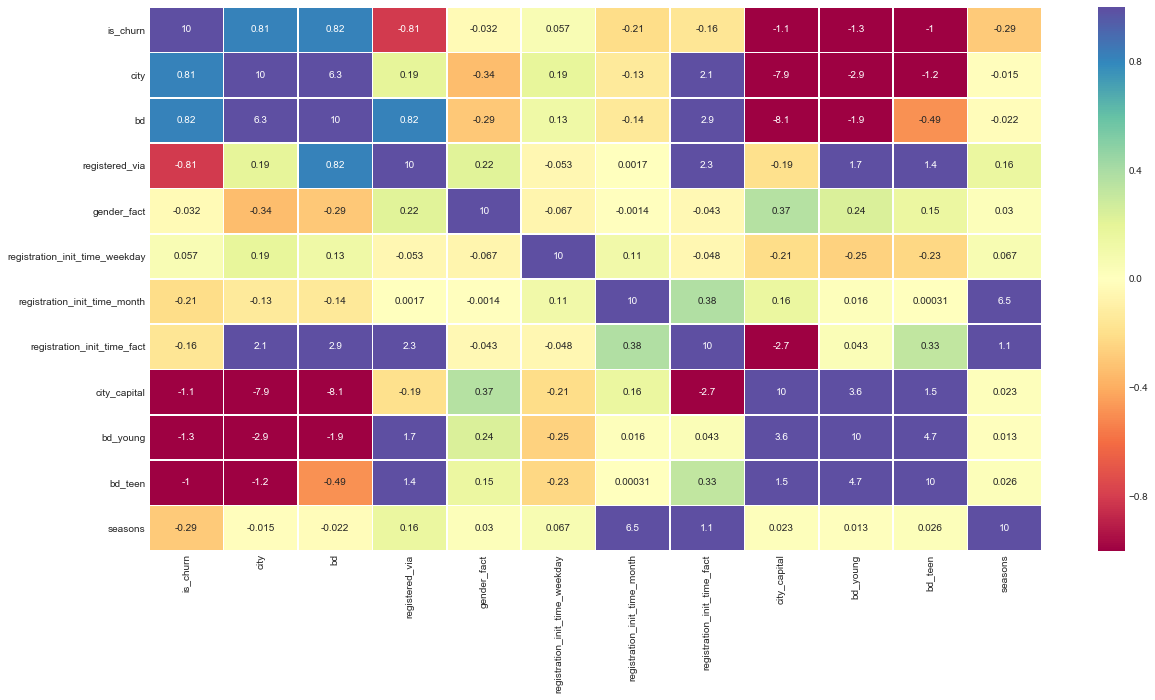

In [79]:
plt.rcParams['figure.figsize']=(20,10)
sns.heatmap(train_members.corr(method='pearson')*10, vmax=1., vmin=-1., annot=True, linewidths=.8, cmap="Spectral");

**Observations**
<br><br>*target_variable x features corr*
1. There is no visible significant correlation with target variable
2. Highest correlation we can see with newly created features *city_capital* & *bd_teen* 

*feature x feature corr*
1. Ther is higher correlation between *registration_init_time* x *city_capital* and *city_capital* x *bd_teen* -> I will create feature for *capital_teens*

we can already drop on this stage not useful columns: registration_init_time_weekday and gender

<br>

In [80]:
train_members['capital_teens'] = (train_members.city_capital == 1) & (train_members.bd_teen == 1)

In [81]:
train_members['capital_young'] = (train_members.city_capital == 1) & (train_members.bd_young == 1)

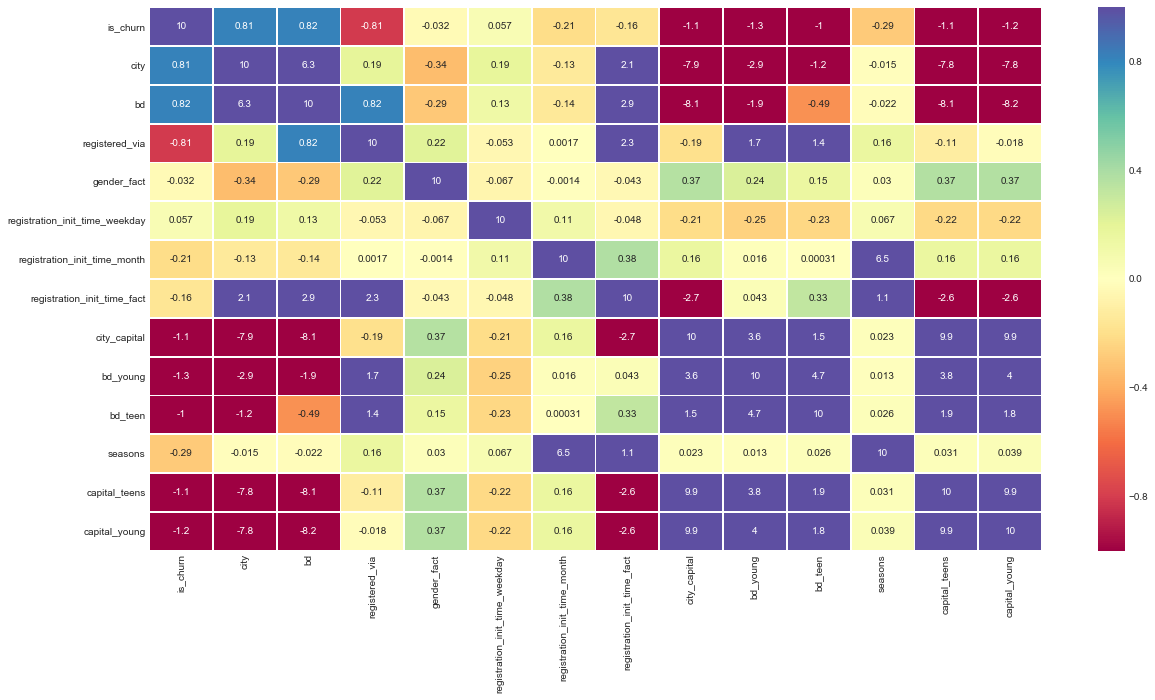

In [82]:
plt.rcParams['figure.figsize']=(20,10)
sns.heatmap(train_members.corr(method='pearson')*10, vmax=1., vmin=-1., annot=True, linewidths=.8, cmap="Spectral");

### 3.2 FE transactions

In [83]:
train_trans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1132036 entries, 0 to 1132035
Data columns (total 17 columns):
msno                           1132036 non-null object
is_churn                       1132036 non-null int64
payment_method_id              1132036 non-null int64
payment_plan_days              1132036 non-null int64
plan_list_price                1132036 non-null int64
actual_amount_paid             1132036 non-null int64
is_auto_renew                  1132036 non-null int64
transaction_date               1132036 non-null object
membership_expire_date         1132036 non-null object
is_cancel                      1132036 non-null int64
discount                       1132036 non-null int64
is_discount                    1132036 non-null int64
transaction_month              1132036 non-null int64
transaction_weekday            1132036 non-null int64
membership_expire_month        1132036 non-null int64
membership_expire_weekday      1132036 non-null int64
membership_expire_da

In [84]:
train_trans['pay_met_is_auto_cat'] = train_trans['payment_method_id']
train_trans['pay_met_is_auto_cat'] = train_trans.pay_met_is_auto_cat.apply(lambda x: 0 if x in [3,6,13,22,20,32,12,17,8,15,35,26,38,28
] else 1)
train_trans['pay_met_is_auto_cat'].value_counts()

1    1065965
0      66071
Name: pay_met_is_auto_cat, dtype: int64

In [85]:
train_trans['transaction_month_cat'] = train_trans['transaction_month']
train_trans['transaction_month_cat'] = train_trans.transaction_month_cat.apply(lambda x: 20 if x in [1,12] else x)
train_trans['transaction_month_cat'] = train_trans.transaction_month_cat.apply(lambda x: 30 if x in [4,5,6,7,8,9,10,11] else x)
train_trans['transaction_month_cat'] = train_trans.transaction_month_cat.apply(lambda x: 40 if x in [2,3] else x)
train_trans['transaction_month_cat'].value_counts()

40    1052782
30      57088
20      22166
Name: transaction_month_cat, dtype: int64

In [86]:
train_trans['transaction_week_friday'] = train_trans['transaction_weekday']
train_trans['transaction_week_friday'] = train_trans.transaction_week_friday.apply(lambda x: 1 if x in [4] else 0)
train_trans['transaction_week_friday'].value_counts()

0    823413
1    308623
Name: transaction_week_friday, dtype: int64

In [87]:
#this correlate with is_churn 0.47 like one below but have higher correlation with is_cancel hence I choose lower one
train_trans['membership_expire_month_cat'] = train_trans['membership_expire_month']
train_trans['membership_expire_month_cat'] = train_trans.membership_expire_month_cat.apply(lambda x: 60 if x in [6,9] else x)
train_trans['membership_expire_month_cat'] = train_trans.membership_expire_month_cat.apply(lambda x: 40 if x in [10,7,3,11,8] else x)
train_trans['membership_expire_month_cat'] = train_trans.membership_expire_month_cat.apply(lambda x: 30 if x in [12,2,1] else x)
train_trans['membership_expire_month_cat'] = train_trans.membership_expire_month_cat.apply(lambda x: 20 if x in [5,4] else x)

In [88]:
train_trans['membership_expire_month_cat'] = train_trans['membership_expire_month']
train_trans['membership_expire_month_cat'] = train_trans.membership_expire_month_cat.apply(lambda x: 60 if x in [6,9] else x)
train_trans['membership_expire_month_cat'] = train_trans.membership_expire_month_cat.apply(lambda x: 50 if x in [10,7] else x)
train_trans['membership_expire_month_cat'] = train_trans.membership_expire_month_cat.apply(lambda x: 40 if x in [3,11,8] else x)
train_trans['membership_expire_month_cat'] = train_trans.membership_expire_month_cat.apply(lambda x: 30 if x in [12,2,1] else x)
train_trans['membership_expire_month_cat'] = train_trans.membership_expire_month_cat.apply(lambda x: 20 if x in [5,4] else x)

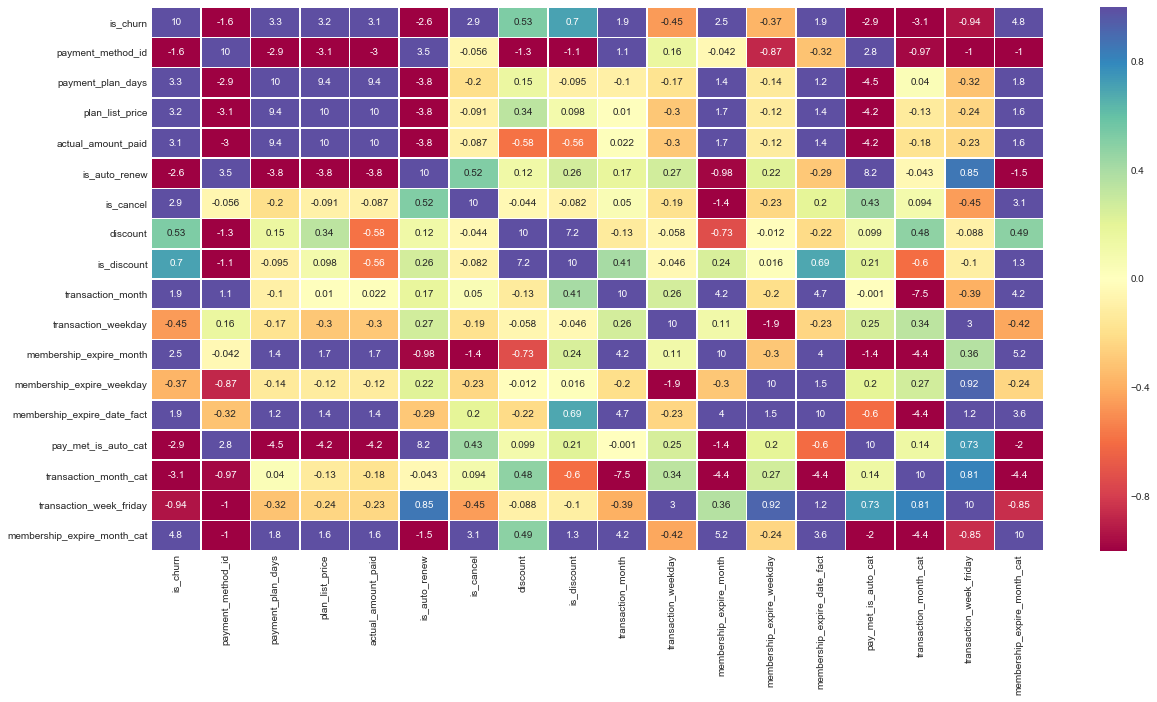

In [89]:
plt.rcParams['figure.figsize']=(20,10)
sns.heatmap(train_trans.corr(method='pearson')*10, vmax=1., vmin=-1., annot=True, linewidths=.8, cmap="Spectral");

**Observations**
<br><br>*target_variable x features corr*
1. Target variable correlate the most with created features *membership_expire_month_cat*, *payment_plan_cat*
2. Few feature with corr>20% suggest that transactions data can have highest importance in models, we will evaluate that
3. I was counting on higher correlation with discount features, let's explore further their importance while testing models

*feature x feature corr*
1. Highest features correlations were already mentioned and analyze in EDA
<br>

# 4. Merge and Model

## 4.1 Merge

In [90]:
train_members.info()
train_trans.info()
train_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 860967 entries, 0 to 860966
Data columns (total 17 columns):
msno                              860967 non-null object
is_churn                          860967 non-null int64
city                              860967 non-null int64
bd                                860967 non-null int64
gender                            860967 non-null object
registered_via                    860967 non-null int64
registration_init_time            860967 non-null object
gender_fact                       860967 non-null int64
registration_init_time_weekday    860967 non-null int64
registration_init_time_month      860967 non-null int64
registration_init_time_fact       860967 non-null int64
city_capital                      860967 non-null int64
bd_young                          860967 non-null int64
bd_teen                           860967 non-null int64
seasons                           860967 non-null int64
capital_teens                     860967 non-n

In [91]:
data_temp = pd.merge(left = train_trans,right = train_user, how = 'outer',on=['msno'])
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1160851 entries, 0 to 1160850
Data columns (total 36 columns):
msno                           1160851 non-null object
is_churn_x                     1132036 non-null float64
payment_method_id              1132036 non-null float64
payment_plan_days              1132036 non-null float64
plan_list_price                1132036 non-null float64
actual_amount_paid             1132036 non-null float64
is_auto_renew                  1132036 non-null float64
transaction_date               1132036 non-null object
membership_expire_date         1132036 non-null object
is_cancel                      1132036 non-null float64
discount                       1132036 non-null float64
is_discount                    1132036 non-null float64
transaction_month              1132036 non-null float64
transaction_weekday            1132036 non-null float64
membership_expire_month        1132036 non-null float64
membership_expire_weekday      1132036 non-null fl

In [92]:
data_temp2 = pd.merge(left = train_members, right = data_temp, how = 'outer',on=['msno'])

In [93]:
del data_temp2['is_churn_x']
del data_temp2['is_churn_y']
del data_temp2['is_churn']
data_temp2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1167640 entries, 0 to 1167639
Data columns (total 49 columns):
msno                              1167640 non-null object
city                              1052582 non-null float64
bd                                1052582 non-null float64
gender                            1052582 non-null object
registered_via                    1052582 non-null float64
registration_init_time            1052582 non-null object
gender_fact                       1052582 non-null float64
registration_init_time_weekday    1052582 non-null float64
registration_init_time_month      1052582 non-null float64
registration_init_time_fact       1052582 non-null float64
city_capital                      1052582 non-null float64
bd_young                          1052582 non-null float64
bd_teen                           1052582 non-null float64
seasons                           1052582 non-null float64
capital_teens                     1052582 non-null object
capita

In [94]:
data = pd.merge(left = data_temp2, right = df_train, how = 'right',on=['msno'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1169418 entries, 0 to 1169417
Data columns (total 50 columns):
msno                              1169418 non-null object
city                              1052582 non-null float64
bd                                1052582 non-null float64
gender                            1052582 non-null object
registered_via                    1052582 non-null float64
registration_init_time            1052582 non-null object
gender_fact                       1052582 non-null float64
registration_init_time_weekday    1052582 non-null float64
registration_init_time_month      1052582 non-null float64
registration_init_time_fact       1052582 non-null float64
city_capital                      1052582 non-null float64
bd_young                          1052582 non-null float64
bd_teen                           1052582 non-null float64
seasons                           1052582 non-null float64
capital_teens                     1052582 non-null object
capita

## 4.2 Preparation dataset functions

In [95]:
cat_feats = data.select_dtypes(include=[np.object]).columns

for cat_feat in cat_feats:
    data['{0}_fact'.format(cat_feat)] = pd.factorize(data[cat_feat] )[0]
    
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1169418 entries, 0 to 1169417
Data columns (total 54 columns):
msno                              1169418 non-null object
city                              1052582 non-null float64
bd                                1052582 non-null float64
gender                            1052582 non-null object
registered_via                    1052582 non-null float64
registration_init_time            1052582 non-null object
gender_fact                       1169418 non-null int64
registration_init_time_weekday    1052582 non-null float64
registration_init_time_month      1052582 non-null float64
registration_init_time_fact       1169418 non-null int64
city_capital                      1052582 non-null float64
bd_young                          1052582 non-null float64
bd_teen                           1052582 non-null float64
seasons                           1052582 non-null float64
capital_teens                     1052582 non-null object
capital_yo

In [96]:
data = data.fillna(-1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1169418 entries, 0 to 1169417
Data columns (total 54 columns):
msno                              1169418 non-null object
city                              1169418 non-null float64
bd                                1169418 non-null float64
gender                            1169418 non-null object
registered_via                    1169418 non-null float64
registration_init_time            1169418 non-null object
gender_fact                       1169418 non-null int64
registration_init_time_weekday    1169418 non-null float64
registration_init_time_month      1169418 non-null float64
registration_init_time_fact       1169418 non-null int64
city_capital                      1169418 non-null float64
bd_young                          1169418 non-null float64
bd_teen                           1169418 non-null float64
seasons                           1169418 non-null float64
capital_teens                     1169418 non-null object
capital_yo

In [97]:
data.bd_teen.value_counts(dropna = False)
data.capital_young.value_counts()

 1.0    1019459
-1.0     116836
 0.0      33123
Name: bd_teen, dtype: int64

False    548617
True     503965
-1       116836
Name: capital_young, dtype: int64

In [98]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1169418 entries, 0 to 1169417
Data columns (total 54 columns):
msno                              1169418 non-null object
city                              1169418 non-null float64
bd                                1169418 non-null float64
gender                            1169418 non-null object
registered_via                    1169418 non-null float64
registration_init_time            1169418 non-null object
gender_fact                       1169418 non-null int64
registration_init_time_weekday    1169418 non-null float64
registration_init_time_month      1169418 non-null float64
registration_init_time_fact       1169418 non-null int64
city_capital                      1169418 non-null float64
bd_young                          1169418 non-null float64
bd_teen                           1169418 non-null float64
seasons                           1169418 non-null float64
capital_teens                     1169418 non-null object
capital_yo

In [99]:
corr = data.corr(method='pearson')
type(corr)
corr.is_churn.sort_values()

pandas.core.frame.DataFrame

transaction_month_cat            -0.455751
pay_met_is_auto_cat              -0.454037
is_auto_renew                    -0.435458
payment_method_id                -0.392010
is_discount                      -0.306369
msno_fact                        -0.263595
transaction_week_friday          -0.243126
transaction_weekday              -0.173084
membership_expire_weekday        -0.155622
is_cancel                        -0.098985
membership_expire_month          -0.052172
num_unq_sum                      -0.037382
total_secs_sum                   -0.036764
num_75_mean                      -0.035834
num_100_sum                      -0.034908
capital_young_fact               -0.032489
num_75_sum                       -0.029395
num_unq_mean                     -0.028528
num_985_mean                     -0.028475
total_secs_mean                  -0.027746
capital_teens_fact               -0.027737
num_100_mean                     -0.027028
num_50_sum                       -0.023811
num_50_mean

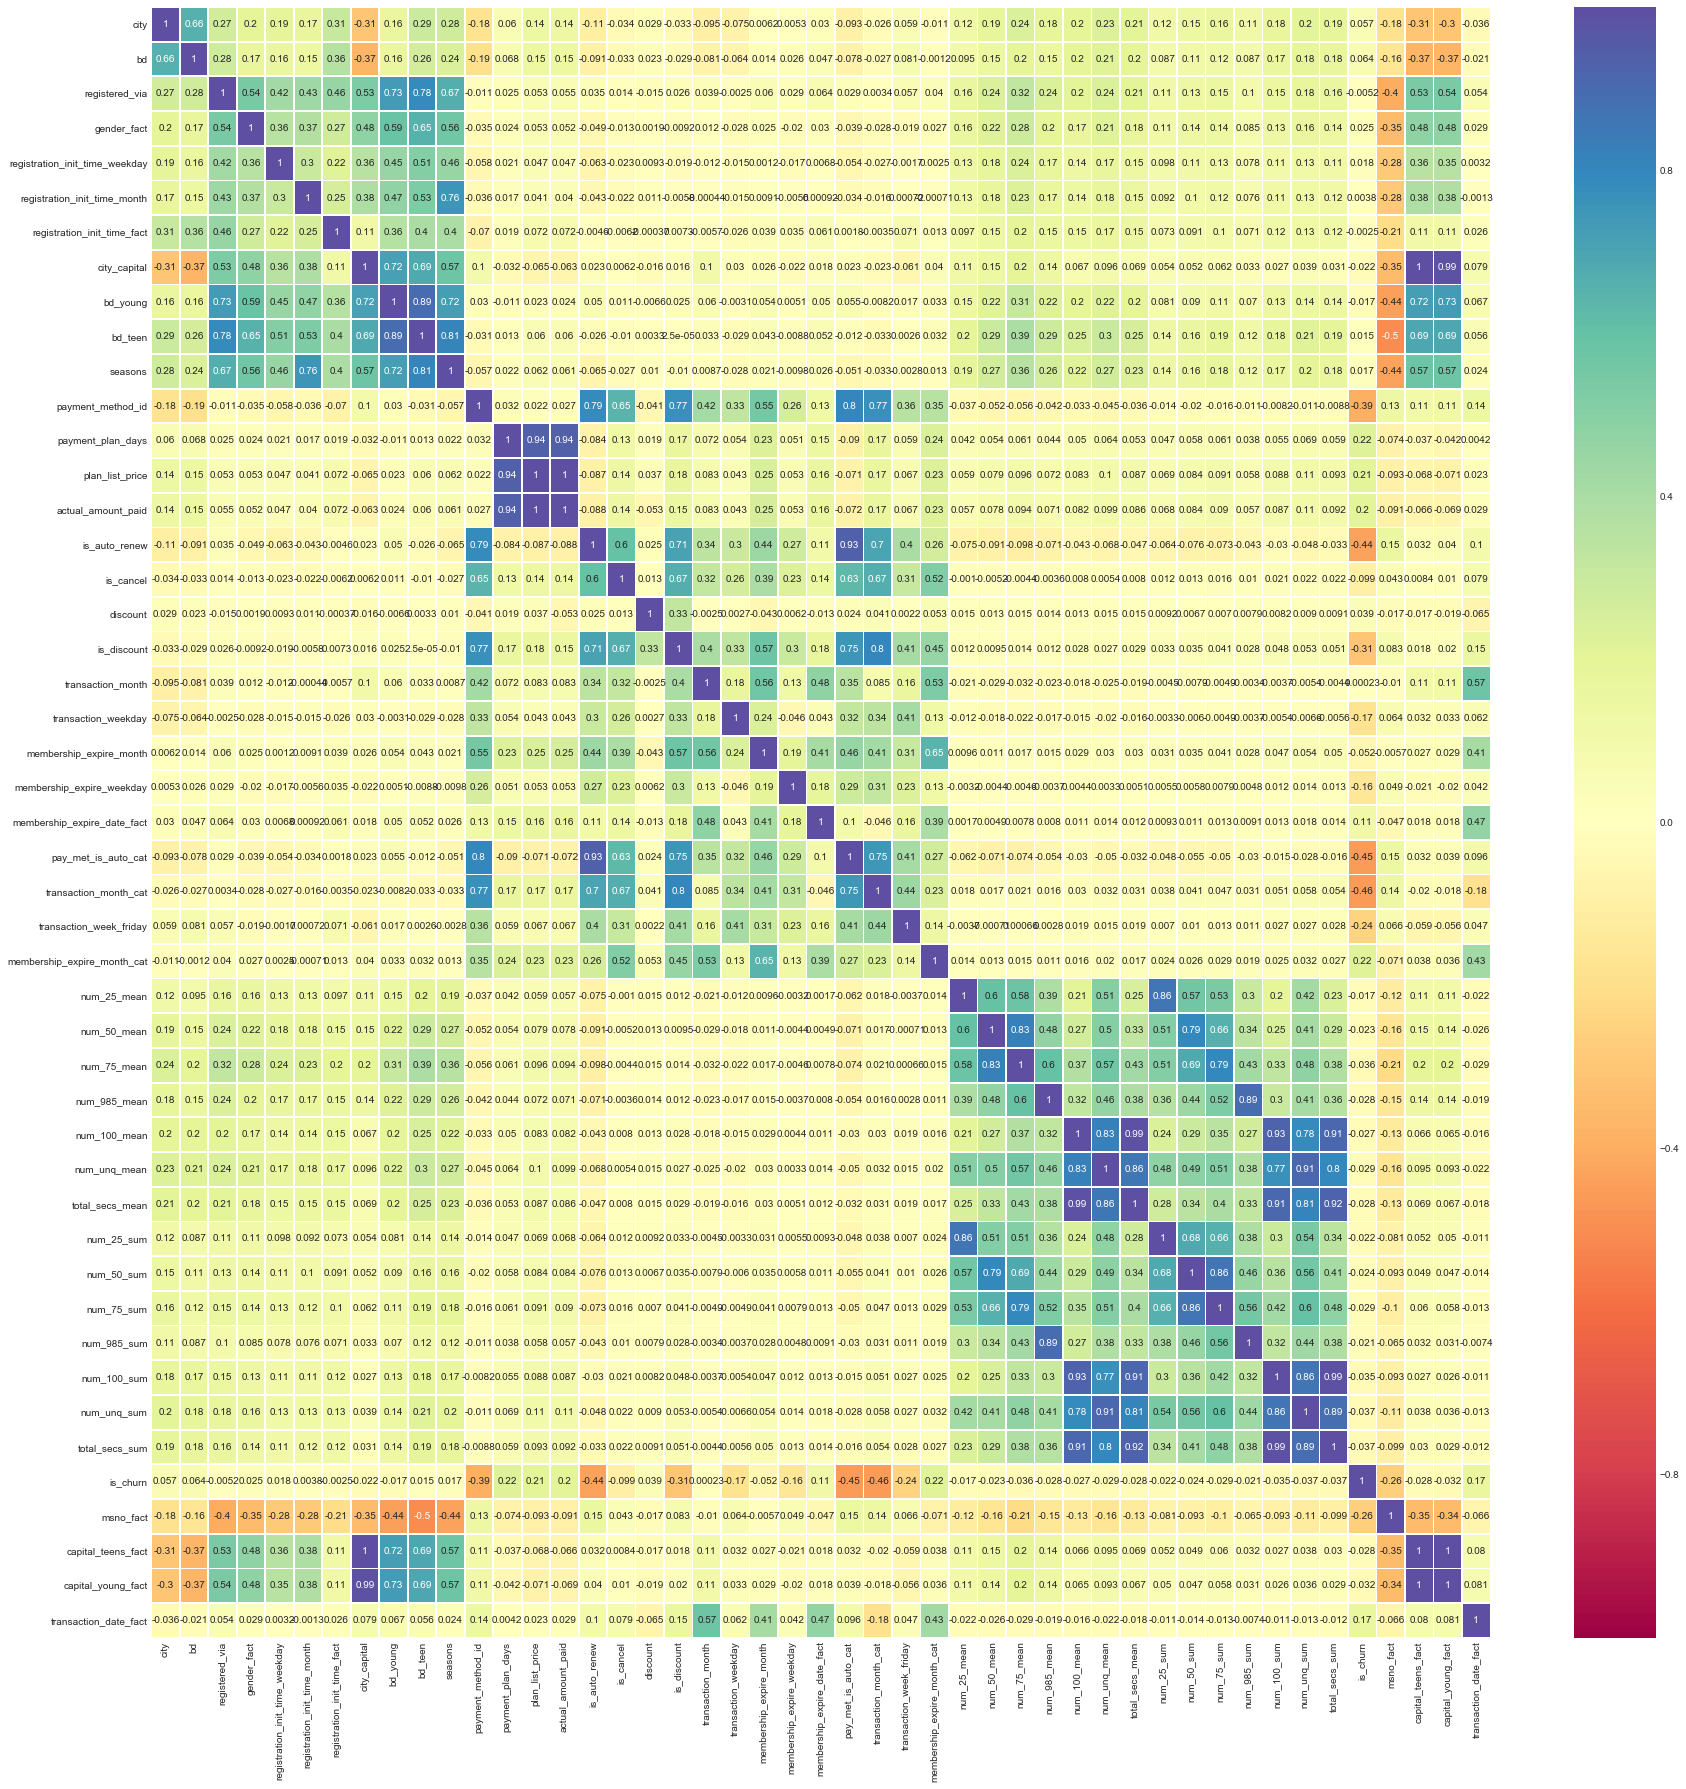

In [100]:
plt.rcParams['figure.figsize']=(30,30)
sns.heatmap(data.corr(method='pearson'), vmax=1., vmin=-1., annot=True, linewidths=.8, cmap="Spectral");

In [101]:
del data['plan_list_price'] #as have high corr with payment_plan_days
del data['actual_amount_paid'] #as have high corr with payment_plan_days

In [102]:
feats = list(data.columns)
rem = ['msno', 'gender', 'registration_init_time', 'capital_teens',
       'capital_young', 'transaction_date', 'membership_expire_date','is_churn', 'msno_fact']
for i in rem:
    feats.remove(i)
feats

['city',
 'bd',
 'registered_via',
 'gender_fact',
 'registration_init_time_weekday',
 'registration_init_time_month',
 'registration_init_time_fact',
 'city_capital',
 'bd_young',
 'bd_teen',
 'seasons',
 'payment_method_id',
 'payment_plan_days',
 'is_auto_renew',
 'is_cancel',
 'discount',
 'is_discount',
 'transaction_month',
 'transaction_weekday',
 'membership_expire_month',
 'membership_expire_weekday',
 'membership_expire_date_fact',
 'pay_met_is_auto_cat',
 'transaction_month_cat',
 'transaction_week_friday',
 'membership_expire_month_cat',
 'num_25_mean',
 'num_50_mean',
 'num_75_mean',
 'num_985_mean',
 'num_100_mean',
 'num_unq_mean',
 'total_secs_mean',
 'num_25_sum',
 'num_50_sum',
 'num_75_sum',
 'num_985_sum',
 'num_100_sum',
 'num_unq_sum',
 'total_secs_sum',
 'capital_teens_fact',
 'capital_young_fact',
 'transaction_date_fact']

In [103]:
len(feats), data.shape

(43, (1169418, 52))

In [104]:
def train_and_predict(model, X, y, test_size=0.33):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)
    
    model.fit(X_train, y_train)    
    y_pred = model.predict(X_test) 
    
    #print(classification_report(y_test, y_pred))
    plt.rcParams['figure.figsize']=(5,5)
    cm = confusion_matrix(y_test,model.predict(X_test))
    sns.heatmap(cm,annot=True,fmt="d")
    return log_loss(y_test, y_pred), f1_score(y_test, y_pred)

In [105]:
def plot_learning_curve(model, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure(figsize=(12,8))
    plt.title(title)
    if ylim is not None:plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring= make_scorer(f1_score))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt



In [106]:
X = data[feats]
y = data['is_churn']
X.head(10)

,city,bd,registered_via,gender_fact,registration_init_time_weekday,registration_init_time_month,registration_init_time_fact,city_capital,bd_young,bd_teen,seasons,payment_method_id,payment_plan_days,is_auto_renew,is_cancel,discount,is_discount,transaction_month,transaction_weekday,membership_expire_month,membership_expire_weekday,membership_expire_date_fact,pay_met_is_auto_cat,transaction_month_cat,transaction_week_friday,membership_expire_month_cat,num_25_mean,num_50_mean,num_75_mean,num_985_mean,num_100_mean,num_unq_mean,total_secs_mean,num_25_sum,num_50_sum,num_75_sum,num_985_sum,num_100_sum,num_unq_sum,total_secs_sum,capital_teens_fact,capital_young_fact,transaction_date_fact
0,5.0,28.0,3.0,0,0.0,12.0,0,0.0,1.0,1.0,2.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0,-1.0,16.909091,2.090909,1.181818,0.909091,28.909091,31.636364,7327.141545,186.0,23.0,13.0,10.0,318.0,348.0,80598.557,0,0,-1
1,13.0,20.0,3.0,0,0.0,12.0,0,0.0,0.0,1.0,2.0,36.0,30.0,0.0,0.0,0.0,0.0,3.0,5.0,4.0,1.0,0,1.0,40.0,0.0,20.0,0.000000,0.666667,0.333333,0.000000,4.333333,5.000000,1164.418167,0.0,4.0,2.0,0.0,26.0,30.0,6986.509,0,0,0
2,13.0,18.0,3.0,0,4.0,12.0,1,0.0,0.0,0.0,2.0,17.0,60.0,0.0,0.0,0.0,0.0,3.0,5.0,3.0,1.0,1,0.0,40.0,0.0,40.0,11.950000,2.850000,1.600000,1.100000,10.250000,21.600000,3390.523350,239.0,57.0,32.0,22.0,205.0,432.0,67810.467,0,0,0
3,13.0,18.0,3.0,0,4.0,12.0,1,0.0,0.0,0.0,2.0,15.0,90.0,0.0,0.0,0.0,0.0,3.0,1.0,6.0,3.0,2,0.0,40.0,0.0,60.0,11.950000,2.850000,1.600000,1.100000,10.250000,21.600000,3390.523350,239.0,57.0,32.0,22.0,205.0,432.0,67810.467,0,0,1
4,1.0,0.0,7.0,1,3.0,1.0,2,1.0,1.0,1.0,1.0,41.0,30.0,1.0,0.0,0.0,0.0,9.0,1.0,6.0,3.0,3,1.0,30.0,0.0,60.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,1,1,2
5,1.0,0.0,7.0,1,3.0,1.0,2,1.0,1.0,1.0,1.0,41.0,30.0,1.0,0.0,0.0,0.0,9.0,1.0,7.0,5.0,4,1.0,30.0,0.0,50.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,1,1,2
6,1.0,0.0,7.0,1,3.0,1.0,2,1.0,1.0,1.0,1.0,41.0,30.0,1.0,0.0,0.0,0.0,12.0,1.0,12.0,4.0,5,1.0,20.0,0.0,30.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,1,1,3
7,1.0,0.0,7.0,1,3.0,1.0,2,1.0,1.0,1.0,1.0,41.0,30.0,1.0,0.0,0.0,0.0,11.0,6.0,10.0,6.0,6,1.0,30.0,0.0,50.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,1,1,4
8,1.0,0.0,7.0,1,3.0,1.0,2,1.0,1.0,1.0,1.0,41.0,30.0,1.0,0.0,0.0,0.0,10.0,3.0,9.0,4.0,7,1.0,30.0,0.0,60.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,1,1,5
9,1.0,0.0,7.0,1,3.0,1.0,2,1.0,1.0,1.0,1.0,41.0,30.0,1.0,0.0,0.0,0.0,10.0,3.0,8.0,1.0,8,1.0,30.0,0.0,40.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,1,1,5


Normalizing features

In [107]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaled_features = scaler.fit_transform(X)
X = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)

print ("Feature space holds %d observations and %d features" % X.shape)
print ("Unique target labels:", np.unique(y))
X.head(10)

Feature space holds 1169418 observations and 43 features
Unique target labels: [0 1]


,city,bd,registered_via,gender_fact,registration_init_time_weekday,registration_init_time_month,registration_init_time_fact,city_capital,bd_young,bd_teen,seasons,payment_method_id,payment_plan_days,is_auto_renew,is_cancel,discount,is_discount,transaction_month,transaction_weekday,membership_expire_month,membership_expire_weekday,membership_expire_date_fact,pay_met_is_auto_cat,transaction_month_cat,transaction_week_friday,membership_expire_month_cat,num_25_mean,num_50_mean,num_75_mean,num_985_mean,num_100_mean,num_unq_mean,total_secs_mean,num_25_sum,num_50_sum,num_75_sum,num_985_sum,num_100_sum,num_unq_sum,total_secs_sum,capital_teens_fact,capital_young_fact,transaction_date_fact
0,0.363636,1.037037,-0.8,-1.0,-0.75,0.857143,-0.679848,0.0,0.0,0.0,0.0,-14.000000,-31.0,-2.0,-1.0,-1.0,-1.0,-4.0,-1.333333,-5.0,-1.00,-1.146667,-2.0,-41.0,-1.0,-21.0,2.875150,1.081981,0.836941,0.495152,0.690013,0.731885,0.635851,1.485437,0.538462,0.411765,0.222222,0.234522,0.242315,0.194131,0.0,0.0,-1.44
1,1.090909,0.740741,-0.8,-1.0,-0.75,0.857143,-0.679848,0.0,-1.0,0.0,0.0,-1.666667,0.0,-1.0,0.0,0.0,0.0,0.0,0.666667,0.0,-0.50,-1.133333,0.0,0.0,0.0,0.0,-0.483305,0.030754,-0.105820,-0.464444,-0.413233,-0.463017,-0.448962,-0.320388,-0.192308,-0.235294,-0.333333,-0.313321,-0.332731,-0.324445,0.0,0.0,-1.40
2,1.090909,0.666667,-0.8,-1.0,0.25,0.857143,-0.679307,0.0,-1.0,-1.0,0.0,-8.000000,30.0,-1.0,0.0,0.0,0.0,0.0,0.666667,-1.0,-0.50,-1.120000,-1.0,0.0,0.0,20.0,1.890184,1.642262,1.301587,0.696667,-0.147624,0.281656,-0.057105,2.000000,1.846154,1.529412,0.888889,0.022514,0.394213,0.104042,0.0,0.0,-1.40
3,1.090909,0.666667,-0.8,-1.0,0.25,0.857143,-0.679307,0.0,-1.0,-1.0,0.0,-8.666667,60.0,-1.0,0.0,0.0,0.0,0.0,-0.666667,2.0,0.00,-1.106667,-1.0,0.0,0.0,40.0,1.890184,1.642262,1.301587,0.696667,-0.147624,0.281656,-0.057105,2.000000,1.846154,1.529412,0.888889,0.022514,0.394213,0.104042,0.0,0.0,-1.36
4,0.000000,0.000000,0.0,0.0,0.00,-0.714286,-0.678765,1.0,0.0,0.0,-1.0,0.000000,0.0,0.0,0.0,0.0,0.0,6.0,-0.666667,2.0,0.00,-1.093333,0.0,-10.0,0.0,40.0,-0.681923,-1.199405,-1.587302,-1.520000,-0.652655,-0.732176,-0.654108,-0.330097,-0.384615,-0.411765,-0.388889,-0.363977,-0.388788,-0.373670,1.0,1.0,-1.32
5,0.000000,0.000000,0.0,0.0,0.00,-0.714286,-0.678765,1.0,0.0,0.0,-1.0,0.000000,0.0,0.0,0.0,0.0,0.0,6.0,-0.666667,3.0,0.50,-1.080000,0.0,-10.0,0.0,30.0,-0.681923,-1.199405,-1.587302,-1.520000,-0.652655,-0.732176,-0.654108,-0.330097,-0.384615,-0.411765,-0.388889,-0.363977,-0.388788,-0.373670,1.0,1.0,-1.32
6,0.000000,0.000000,0.0,0.0,0.00,-0.714286,-0.678765,1.0,0.0,0.0,-1.0,0.000000,0.0,0.0,0.0,0.0,0.0,9.0,-0.666667,8.0,0.25,-1.066667,0.0,-20.0,0.0,10.0,-0.681923,-1.199405,-1.587302,-1.520000,-0.652655,-0.732176,-0.654108,-0.330097,-0.384615,-0.411765,-0.388889,-0.363977,-0.388788,-0.373670,1.0,1.0,-1.28
7,0.000000,0.000000,0.0,0.0,0.00,-0.714286,-0.678765,1.0,0.0,0.0,-1.0,0.000000,0.0,0.0,0.0,0.0,0.0,8.0,1.000000,6.0,0.75,-1.053333,0.0,-10.0,0.0,30.0,-0.681923,-1.199405,-1.587302,-1.520000,-0.652655,-0.732176,-0.654108,-0.330097,-0.384615,-0.411765,-0.388889,-0.363977,-0.388788,-0.373670,1.0,1.0,-1.24
8,0.000000,0.000000,0.0,0.0,0.00,-0.714286,-0.678765,1.0,0.0,0.0,-1.0,0.000000,0.0,0.0,0.0,0.0,0.0,7.0,0.000000,5.0,0.25,-1.040000,0.0,-10.0,0.0,40.0,-0.681923,-1.199405,-1.587302,-1.520000,-0.652655,-0.732176,-0.654108,-0.330097,-0.384615,-0.411765,-0.388889,-0.363977,-0.388788,-0.373670,1.0,1.0,-1.20
9,0.000000,0.000000,0.0,0.0,0.00,-0.714286,-0.678765,1.0,0.0,0.0,-1.0,0.000000,0.0,0.0,0.0,0.0,0.0,7.0,0.000000,4.0,-0.50,-1.026667,0.0,-10.0,0.0,20.0,-0.681923,-1.199405,-1.587302,-1.520000,-0.652655,-0.732176,-0.654108,-0.330097,-0.384615,-0.411765,-0.388889,-0.363977,-0.388788,-0.373670,1.0,1.0,-1.20


In [108]:
X.head(10)
X.registered_via.value_counts()

,city,bd,registered_via,gender_fact,registration_init_time_weekday,registration_init_time_month,registration_init_time_fact,city_capital,bd_young,bd_teen,seasons,payment_method_id,payment_plan_days,is_auto_renew,is_cancel,discount,is_discount,transaction_month,transaction_weekday,membership_expire_month,membership_expire_weekday,membership_expire_date_fact,pay_met_is_auto_cat,transaction_month_cat,transaction_week_friday,membership_expire_month_cat,num_25_mean,num_50_mean,num_75_mean,num_985_mean,num_100_mean,num_unq_mean,total_secs_mean,num_25_sum,num_50_sum,num_75_sum,num_985_sum,num_100_sum,num_unq_sum,total_secs_sum,capital_teens_fact,capital_young_fact,transaction_date_fact
0,0.363636,1.037037,-0.8,-1.0,-0.75,0.857143,-0.679848,0.0,0.0,0.0,0.0,-14.000000,-31.0,-2.0,-1.0,-1.0,-1.0,-4.0,-1.333333,-5.0,-1.00,-1.146667,-2.0,-41.0,-1.0,-21.0,2.875150,1.081981,0.836941,0.495152,0.690013,0.731885,0.635851,1.485437,0.538462,0.411765,0.222222,0.234522,0.242315,0.194131,0.0,0.0,-1.44
1,1.090909,0.740741,-0.8,-1.0,-0.75,0.857143,-0.679848,0.0,-1.0,0.0,0.0,-1.666667,0.0,-1.0,0.0,0.0,0.0,0.0,0.666667,0.0,-0.50,-1.133333,0.0,0.0,0.0,0.0,-0.483305,0.030754,-0.105820,-0.464444,-0.413233,-0.463017,-0.448962,-0.320388,-0.192308,-0.235294,-0.333333,-0.313321,-0.332731,-0.324445,0.0,0.0,-1.40
2,1.090909,0.666667,-0.8,-1.0,0.25,0.857143,-0.679307,0.0,-1.0,-1.0,0.0,-8.000000,30.0,-1.0,0.0,0.0,0.0,0.0,0.666667,-1.0,-0.50,-1.120000,-1.0,0.0,0.0,20.0,1.890184,1.642262,1.301587,0.696667,-0.147624,0.281656,-0.057105,2.000000,1.846154,1.529412,0.888889,0.022514,0.394213,0.104042,0.0,0.0,-1.40
3,1.090909,0.666667,-0.8,-1.0,0.25,0.857143,-0.679307,0.0,-1.0,-1.0,0.0,-8.666667,60.0,-1.0,0.0,0.0,0.0,0.0,-0.666667,2.0,0.00,-1.106667,-1.0,0.0,0.0,40.0,1.890184,1.642262,1.301587,0.696667,-0.147624,0.281656,-0.057105,2.000000,1.846154,1.529412,0.888889,0.022514,0.394213,0.104042,0.0,0.0,-1.36
4,0.000000,0.000000,0.0,0.0,0.00,-0.714286,-0.678765,1.0,0.0,0.0,-1.0,0.000000,0.0,0.0,0.0,0.0,0.0,6.0,-0.666667,2.0,0.00,-1.093333,0.0,-10.0,0.0,40.0,-0.681923,-1.199405,-1.587302,-1.520000,-0.652655,-0.732176,-0.654108,-0.330097,-0.384615,-0.411765,-0.388889,-0.363977,-0.388788,-0.373670,1.0,1.0,-1.32
5,0.000000,0.000000,0.0,0.0,0.00,-0.714286,-0.678765,1.0,0.0,0.0,-1.0,0.000000,0.0,0.0,0.0,0.0,0.0,6.0,-0.666667,3.0,0.50,-1.080000,0.0,-10.0,0.0,30.0,-0.681923,-1.199405,-1.587302,-1.520000,-0.652655,-0.732176,-0.654108,-0.330097,-0.384615,-0.411765,-0.388889,-0.363977,-0.388788,-0.373670,1.0,1.0,-1.32
6,0.000000,0.000000,0.0,0.0,0.00,-0.714286,-0.678765,1.0,0.0,0.0,-1.0,0.000000,0.0,0.0,0.0,0.0,0.0,9.0,-0.666667,8.0,0.25,-1.066667,0.0,-20.0,0.0,10.0,-0.681923,-1.199405,-1.587302,-1.520000,-0.652655,-0.732176,-0.654108,-0.330097,-0.384615,-0.411765,-0.388889,-0.363977,-0.388788,-0.373670,1.0,1.0,-1.28
7,0.000000,0.000000,0.0,0.0,0.00,-0.714286,-0.678765,1.0,0.0,0.0,-1.0,0.000000,0.0,0.0,0.0,0.0,0.0,8.0,1.000000,6.0,0.75,-1.053333,0.0,-10.0,0.0,30.0,-0.681923,-1.199405,-1.587302,-1.520000,-0.652655,-0.732176,-0.654108,-0.330097,-0.384615,-0.411765,-0.388889,-0.363977,-0.388788,-0.373670,1.0,1.0,-1.24
8,0.000000,0.000000,0.0,0.0,0.00,-0.714286,-0.678765,1.0,0.0,0.0,-1.0,0.000000,0.0,0.0,0.0,0.0,0.0,7.0,0.000000,5.0,0.25,-1.040000,0.0,-10.0,0.0,40.0,-0.681923,-1.199405,-1.587302,-1.520000,-0.652655,-0.732176,-0.654108,-0.330097,-0.384615,-0.411765,-0.388889,-0.363977,-0.388788,-0.373670,1.0,1.0,-1.20
9,0.000000,0.000000,0.0,0.0,0.00,-0.714286,-0.678765,1.0,0.0,0.0,-1.0,0.000000,0.0,0.0,0.0,0.0,0.0,7.0,0.000000,4.0,-0.50,-1.026667,0.0,-10.0,0.0,20.0,-0.681923,-1.199405,-1.587302,-1.520000,-0.652655,-0.732176,-0.654108,-0.330097,-0.384615,-0.411765,-0.388889,-0.363977,-0.388788,-0.373670,1.0,1.0,-1.20


 0.0    556735
 0.4    297599
-0.8    132197
-1.6    116836
-0.6     62425
 1.2      3626
Name: registered_via, dtype: int64

## 4.3 Models

In [109]:
model = DecisionTreeClassifier(max_depth = 10)

(1.4954680932518694, 0.8176689473052453)

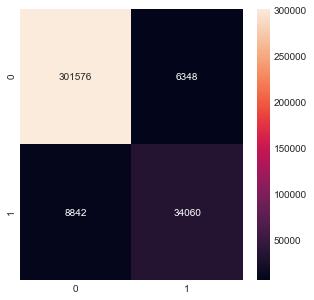

In [110]:
train_and_predict(model, X, y)

## SUCESS METRICS
We will use few success metrics to understand which model is best for us:

<font color='green'>**Kaggle requested measure**</font>
<br>**Logloss** - I personally don't use logloss to this kind of problem. It's more commonly used in evaluation of DL models.
<br><br>
<font color='green'>**Classification measures**</font>
<br>Positive - churn
<br>Negative - not churn

Our focuse will be on those two areas:
<br>**True Positive -> max**
<br>**False Negative -> min**
<br>Our goal is to detect and correctly classified as many clients with potential to churn as possible.

<br>Considering that giving discount to person wrongly classified as churn (False Positive) can impact revenue, we should as well look on tis measure

<br>**F1_score** as this is common success metric for classiification problems like Churn. It gives us picture of correctly clasified Positives

## CROSS VALIDATION
To avoid overfitting let's use cross validation. As our target variable is not balanced(91% of users in training dataset is going for renewal) better to use StratifiedkFold to ensure that in each fold we will have balanced data.

In [111]:
def get_kfold_results(model, X, y, n_folds = 5):
    global X_train
    global y_train
    for train_idx, test_idx in StratifiedKFold(n_splits = n_folds).split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        score = log_loss(y_test, y_pred), f1_score(y_test, y_pred)
        
    plt.rcParams['figure.figsize']=(5,5)
    cm = confusion_matrix(y_test,model.predict(X_test))
    sns.heatmap(cm,annot=True,fmt="d")
    
    return score

In [112]:
type(model)

sklearn.tree.tree.DecisionTreeClassifier

(1.4531373312198745, 0.8169710948253415)

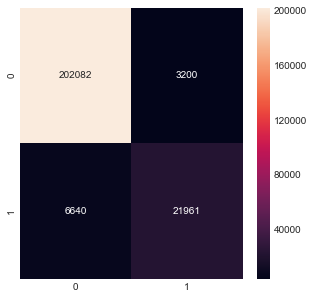

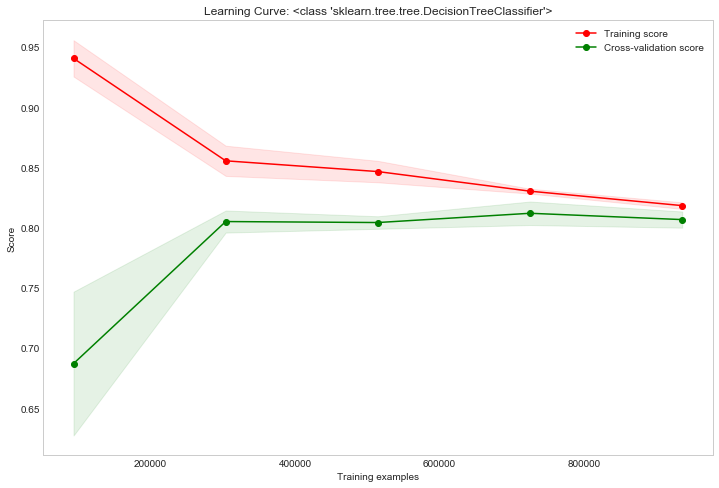

In [113]:
model = DecisionTreeClassifier(max_depth = 10, random_state=123)
get_kfold_results(model, X, y, n_folds=5)

plt = plot_learning_curve(model, "Learning Curve: {0}".format(type(model)), X, y, cv=5, n_jobs=-1) 
plt.show()

(1.9169840241314184, 0.7378581958440195)

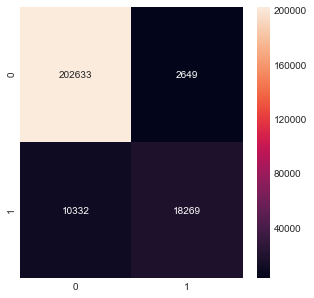

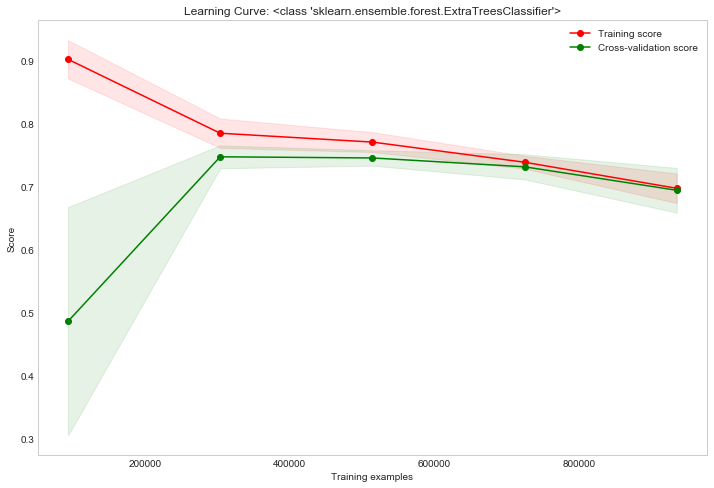

In [114]:
model = ExtraTreesClassifier(max_depth = 10, random_state=123)
get_kfold_results(model, X, y, n_folds=5)

plt = plot_learning_curve(model, "Learning Curve: {0}".format(type(model)), X, y, cv=5, n_jobs=-1) 
plt.show()

(1.5463201104535509, 0.8019893723643652)

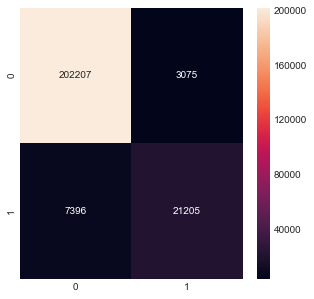

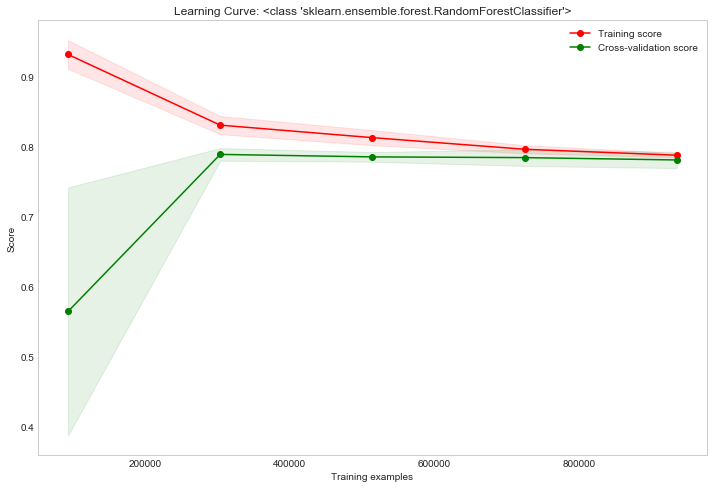

In [115]:
model = RandomForestClassifier(max_depth = 10, random_state=123)
get_kfold_results(model, X, y, n_folds=5)

plt = plot_learning_curve(model, "Learning Curve: {0}".format(type(model)), X, y, cv=5, n_jobs=-1) 
plt.show()

## FEATURES SELECTION - KBest method

In [116]:
def features_selection(score_func, k, X, y):
    select_feature = SelectKBest(score_func, k).fit(X, y)
   
    a = select_feature.scores_
    b = X_train.columns.values

    score_KBest = pd.DataFrame({'scores':a, 'features':b})
    
    return score_KBest.sort_values(by = 'scores', ascending = False)
#score_KBest.sort_values(by = 'scores', ascending = False).iloc[0:k]

In [117]:
#KBest_feats = features_selection(f_classif, 15, X_train, y_train).iloc[0:15]
KBest_feats = features_selection(f_classif, 15, X_train, y_train)
KBest_feats

,features,scores
22,pay_met_is_auto_cat,243165.248800
23,transaction_month_cat,237898.989584
13,is_auto_renew,217667.809012
11,payment_method_id,169354.369692
16,is_discount,94616.735390
24,transaction_week_friday,59485.954280
12,payment_plan_days,55892.558402
25,membership_expire_month_cat,42231.488165
18,transaction_weekday,28266.260695
42,transaction_date_fact,24920.516071


In [118]:
from sklearn.feature_selection import RFE
rfe = RFE(model, 15)
fit = rfe.fit(X_train, y_train)
print("Num Features:", fit.n_features_)
print("Selected Features:", X.columns[fit.support_])
print("Feature Ranking:", fit.ranking_)


Num Features: 15
Selected Features: Index(['payment_method_id', 'payment_plan_days', 'is_auto_renew', 'is_cancel',
       'transaction_month', 'membership_expire_month',
       'membership_expire_date_fact', 'pay_met_is_auto_cat',
       'transaction_month_cat', 'membership_expire_month_cat', 'num_100_mean',
       'num_25_sum', 'num_unq_sum', 'total_secs_sum', 'transaction_date_fact'],
      dtype='object')
Feature Ranking: [19  6 10 28 24 22 13 26 25 29 27  1  1  1  1  9 15  1  3  1 21  1  1  1
  7  1 17 23 20 14  1  5 16  1  8  4  2 12  1  1 18 11  1]


Removing features that highly correlated with other feature which is higher in ranking for feature selection

In [119]:
feats2= list(data.columns)
rem = ['msno', 'gender', 'registration_init_time', 'capital_teens', 'capital_young', 'transaction_date', 
       'membership_expire_date','is_churn', 'msno_fact', 'membership_expire_month','transaction_date_fact', 
       'transaction_week_friday','transaction_weekday','membership_expire_weekday','bd_teen','membership_expire_date_fact',
       'capital_teens_fact','bd','city']
for i in rem:
    feats2.remove(i)

In [120]:
X = data[feats2]
y = data['is_churn']
X.head(10)

,registered_via,gender_fact,registration_init_time_weekday,registration_init_time_month,registration_init_time_fact,city_capital,bd_young,seasons,payment_method_id,payment_plan_days,is_auto_renew,is_cancel,discount,is_discount,transaction_month,pay_met_is_auto_cat,transaction_month_cat,membership_expire_month_cat,num_25_mean,num_50_mean,num_75_mean,num_985_mean,num_100_mean,num_unq_mean,total_secs_mean,num_25_sum,num_50_sum,num_75_sum,num_985_sum,num_100_sum,num_unq_sum,total_secs_sum,capital_young_fact
0,3.0,0,0.0,12.0,0,0.0,1.0,2.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,16.909091,2.090909,1.181818,0.909091,28.909091,31.636364,7327.141545,186.0,23.0,13.0,10.0,318.0,348.0,80598.557,0
1,3.0,0,0.0,12.0,0,0.0,0.0,2.0,36.0,30.0,0.0,0.0,0.0,0.0,3.0,1.0,40.0,20.0,0.000000,0.666667,0.333333,0.000000,4.333333,5.000000,1164.418167,0.0,4.0,2.0,0.0,26.0,30.0,6986.509,0
2,3.0,0,4.0,12.0,1,0.0,0.0,2.0,17.0,60.0,0.0,0.0,0.0,0.0,3.0,0.0,40.0,40.0,11.950000,2.850000,1.600000,1.100000,10.250000,21.600000,3390.523350,239.0,57.0,32.0,22.0,205.0,432.0,67810.467,0
3,3.0,0,4.0,12.0,1,0.0,0.0,2.0,15.0,90.0,0.0,0.0,0.0,0.0,3.0,0.0,40.0,60.0,11.950000,2.850000,1.600000,1.100000,10.250000,21.600000,3390.523350,239.0,57.0,32.0,22.0,205.0,432.0,67810.467,0
4,7.0,1,3.0,1.0,2,1.0,1.0,1.0,41.0,30.0,1.0,0.0,0.0,0.0,9.0,1.0,30.0,60.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,1
5,7.0,1,3.0,1.0,2,1.0,1.0,1.0,41.0,30.0,1.0,0.0,0.0,0.0,9.0,1.0,30.0,50.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,1
6,7.0,1,3.0,1.0,2,1.0,1.0,1.0,41.0,30.0,1.0,0.0,0.0,0.0,12.0,1.0,20.0,30.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,1
7,7.0,1,3.0,1.0,2,1.0,1.0,1.0,41.0,30.0,1.0,0.0,0.0,0.0,11.0,1.0,30.0,50.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,1
8,7.0,1,3.0,1.0,2,1.0,1.0,1.0,41.0,30.0,1.0,0.0,0.0,0.0,10.0,1.0,30.0,60.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,1
9,7.0,1,3.0,1.0,2,1.0,1.0,1.0,41.0,30.0,1.0,0.0,0.0,0.0,10.0,1.0,30.0,40.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,1


(1.8526007534883855, 0.7580100692502073)

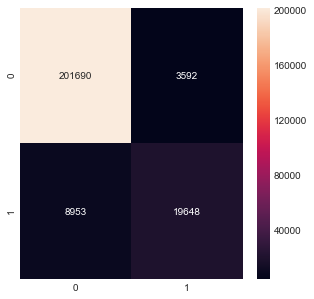

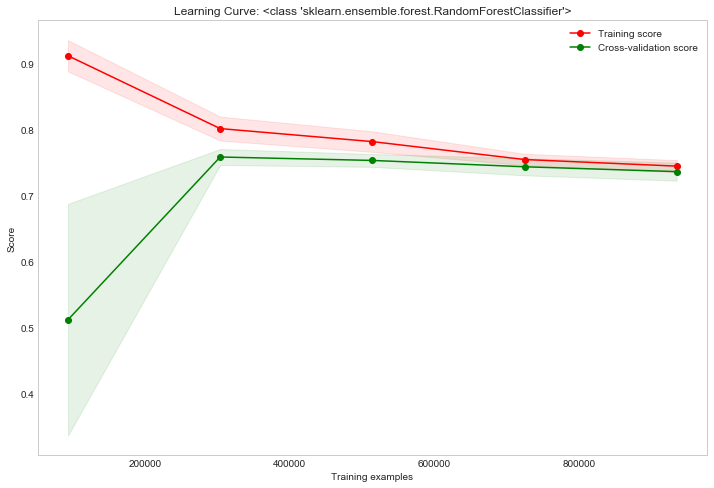

In [121]:
model = RandomForestClassifier(max_depth = 10, random_state=123)
get_kfold_results(model, X, y, n_folds=5)

plt = plot_learning_curve(model, "Learning Curve: {0}".format(type(model)), X, y, cv=5, n_jobs=-1) 
plt.show()

Feature space holds 1169418 observations and 15 features
Unique target labels: [0 1]


(1.5432189465950896, 0.8025097327739351)

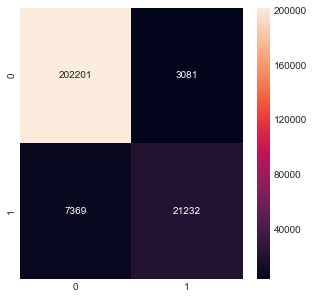

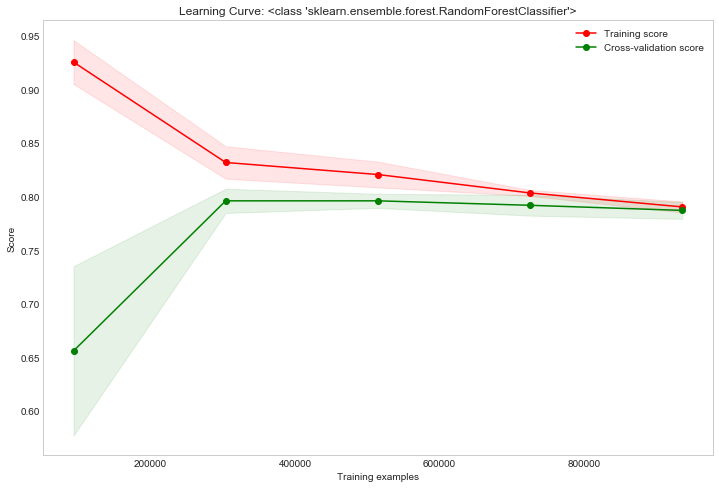

In [122]:
# 15 features from RFE
feats3=['payment_method_id',   'payment_plan_days',   'is_auto_renew',   'is_cancel',   'transaction_month',   'membership_expire_month',   'membership_expire_date_fact',   'pay_met_is_auto_cat',   'transaction_month_cat',   'membership_expire_month_cat',   'num_100_mean',   'num_25_sum',   'num_unq_sum',   'total_secs_sum',   'transaction_date_fact']  

X = data[feats3]
y = data['is_churn']

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaled_features = scaler.fit_transform(X)
X = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)

print ("Feature space holds %d observations and %d features" % X.shape)
print ("Unique target labels:", np.unique(y))

model = RandomForestClassifier(max_depth = 10, random_state=123)
get_kfold_results(model, X, y, n_folds=5)

plt = plot_learning_curve(model, "Learning Curve: {0}".format(type(model)), X, y, cv=5, n_jobs=-1) 
plt.show()

Feature space holds 1169418 observations and 25 features
Unique target labels: [0 1]


(1.5507507909336793, 0.8022224314907241)

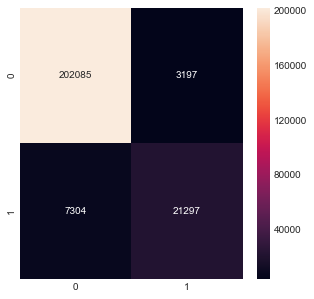

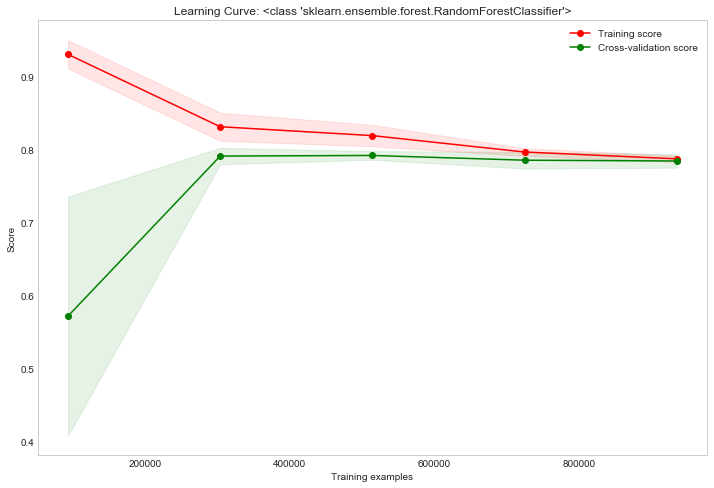

In [123]:
# 25 features from kbest method
feats4 = ['pay_met_is_auto_cat',   'transaction_month_cat',   'is_auto_renew',   'payment_method_id',   'is_discount',   'transaction_week_friday',   'payment_plan_days',   'membership_expire_month_cat',   'transaction_weekday',   'transaction_date_fact',   'membership_expire_weekday',   'is_cancel',   'bd_young',   'membership_expire_date_fact',   'bd_teen',   'capital_young_fact',   'capital_teens_fact',   'city_capital',   'registered_via',   'num_75_mean',   'bd',   'num_unq_sum',   'membership_expire_month',   'city',   'total_secs_sum']
X = data[feats4]
y = data['is_churn']

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaled_features = scaler.fit_transform(X)
X = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)

print ("Feature space holds %d observations and %d features" % X.shape)
print ("Unique target labels:", np.unique(y))

model = RandomForestClassifier(max_depth = 10, random_state=123)
get_kfold_results(model, X, y, n_folds=5)

plt = plot_learning_curve(model, "Learning Curve: {0}".format(type(model)), X, y, cv=5, n_jobs=-1) 
plt.show()

Feature space holds 1169418 observations and 18 features
Unique target labels: [0 1]


(1.5579868809622655, 0.8011010142905622)

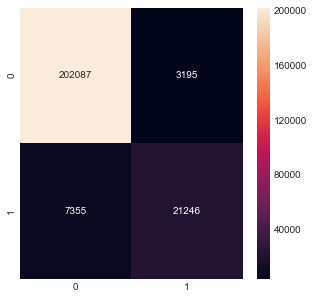

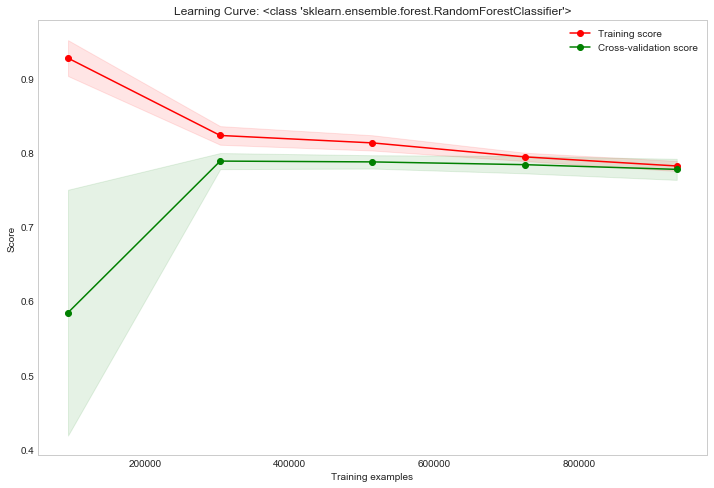

In [124]:
#18 features from kbest method and RFE combination
feats5 = ['payment_method_id',   'payment_plan_days',   'is_auto_renew',   'is_cancel',   'transaction_month',   'membership_expire_month',   'pay_met_is_auto_cat',   'num_100_mean',   'num_25_sum',   'num_unq_sum',   'total_secs_sum',   'transaction_date_fact',   'is_discount',   'bd_young',   'capital_young_fact',   'city_capital',   'registered_via',   'num_75_mean']
X = data[feats5]
y = data['is_churn']

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaled_features = scaler.fit_transform(X)
X = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)

print ("Feature space holds %d observations and %d features" % X.shape)
print ("Unique target labels:", np.unique(y))

model = RandomForestClassifier(max_depth = 10, random_state=123)
get_kfold_results(model, X, y, n_folds=5)

plt = plot_learning_curve(model, "Learning Curve: {0}".format(type(model)), X, y, cv=5, n_jobs=-1) 
plt.show()

In [125]:
# trying with 20 RFE features
from sklearn.feature_selection import RFE
rfe = RFE(model, 20)
fit = rfe.fit(X_train, y_train)
print("Num Features:", fit.n_features_)
print("Selected Features:", X.columns[fit.support_])
print("Feature Ranking:", fit.ranking_)

Num Features: 18
Selected Features: Index(['payment_method_id', 'payment_plan_days', 'is_auto_renew', 'is_cancel',
       'transaction_month', 'membership_expire_month', 'pay_met_is_auto_cat',
       'num_100_mean', 'num_25_sum', 'num_unq_sum', 'total_secs_sum',
       'transaction_date_fact', 'is_discount', 'bd_young',
       'capital_young_fact', 'city_capital', 'registered_via', 'num_75_mean'],
      dtype='object')
Feature Ranking: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


Feature space holds 1169418 observations and 18 features
Unique target labels: [0 1]


(1.5579868809622655, 0.8011010142905622)

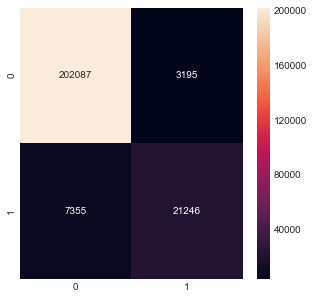

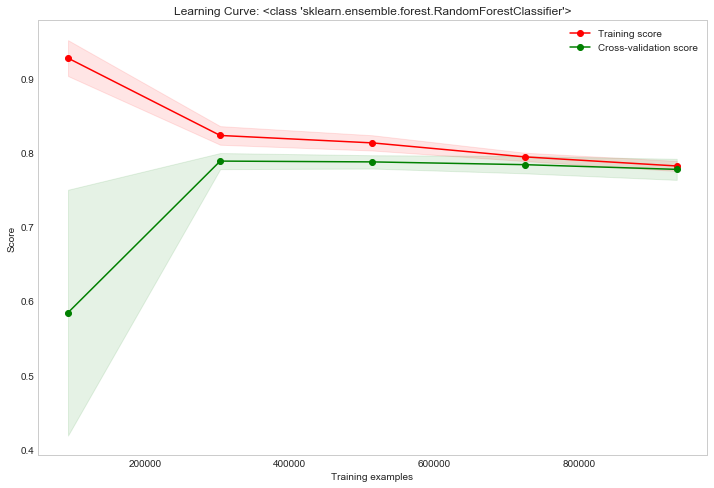

In [126]:
# 18 features from RFE
#(1.523135099580479, 0.8056089562365714)
f_temp = X.columns[fit.support_]
feats6 = f_temp.values.tolist()
X = data[feats6]
y = data['is_churn']

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaled_features = scaler.fit_transform(X)
X = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)

print ("Feature space holds %d observations and %d features" % X.shape)
print ("Unique target labels:", np.unique(y))

model = RandomForestClassifier(max_depth = 10, random_state=123)
get_kfold_results(model, X, y, n_folds=5)

plt = plot_learning_curve(model, "Learning Curve: {0}".format(type(model)), X, y, cv=5, n_jobs=-1) 
plt.show()

Feature ranking:
1. feature 1 (0.151281)
2. feature 11 (0.142439)
3. feature 5 (0.132751)
4. feature 6 (0.098358)
5. feature 0 (0.095461)
6. feature 4 (0.093858)
7. feature 3 (0.084473)
8. feature 2 (0.057343)
9. feature 12 (0.038241)
10. feature 9 (0.031333)
11. feature 8 (0.024267)
12. feature 10 (0.018121)
13. feature 7 (0.012412)
14. feature 17 (0.008207)
15. feature 16 (0.004251)
16. feature 15 (0.003524)
17. feature 14 (0.002155)
18. feature 13 (0.001525)


Text(0.5,1,'Feature importances')

<Container object of 18 artists>

([<matplotlib.axis.XTick at 0x268ec241e48>,
 <a list of 18 Text xticklabel objects>)

(-1, 18)

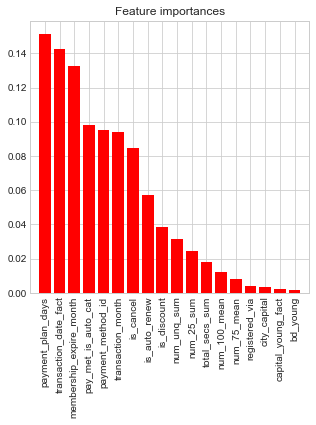

In [127]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

### Hyperopt

SCORE Logloss: 1.5454347210217922
SCORE Logloss: 1.4134129370327928
SCORE Logloss: 1.487103056505378
SCORE Logloss: 1.4422100422123576
SCORE Logloss: 1.5599070651810005
SCORE Logloss: 1.3933294113846713
SCORE Logloss: 1.584716324766806
SCORE Logloss: 1.4346784132576913
SCORE Logloss: 1.5290424593096574
SCORE Logloss: 1.5571011393948857
The best params:  {'x_max_depth': 20.0, 'x_max_features': 15.0, 'x_n_estimators': 20.0}


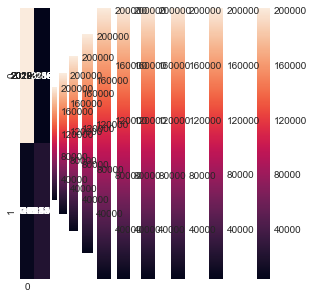

In [132]:
def objective(space):
    
    rf_params = {
        'max_depth':int(space['max_depth']),
        #'min_samples_leaf': space['min_samples_leaf'],
        'n_estimators': int(space['n_estimators']),
        'max_features': int(space['max_features']),
    }
    
    model = RandomForestClassifier(n_jobs=-1,**rf_params)
    score = get_kfold_results(model, X, y, n_folds=5)[0]
    
    print("SCORE Logloss: {0}".format(score))
    
    return{'loss':score, 'status': STATUS_OK }
    
space ={
    'max_depth': hp.quniform ('x_max_depth', 3, 20, 1),
    #'min_samples_leaf': hp.uniform('x_min_samples_leaf', 0.0005, 0.02),
    'n_estimators': hp.quniform('x_n_estimators', 10, 100, 5),
    'max_features': hp.quniform('x_max_features', 1, 18, 1)
}

trials = Trials()
best_params_max_f_rf = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=10),
            max_evals=30,
            trials=trials)

print("The best params: ", best_params_max_f_rf)

### Random Forest Tuned

Feature space holds 1169418 observations and 18 features
Unique target labels: [0 1]


(1.4596070945638981, 0.8191191487959942)

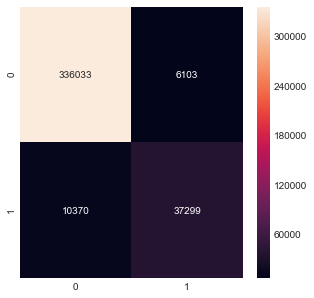

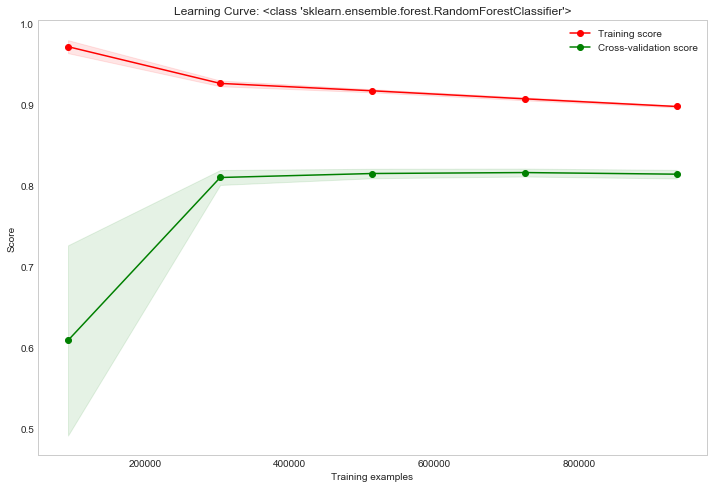

In [ ]:
# 18 features from RFE
#(1.523135099580479, 0.8056089562365714)
#f_temp = X.columns[fit.support_]
#feats6 = f_temp.values.tolist()
X = data[feats6]
y = data['is_churn']

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaled_features = scaler.fit_transform(X)
X = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)

print ("Feature space holds %d observations and %d features" % X.shape)
print ("Unique target labels:", np.unique(y))

model = RandomForestClassifier(max_depth = 20, n_estimators = 20, max_features = 15, random_state=123)
get_kfold_results(model, X, y, n_folds=3)

plt = plot_learning_curve(model, "Learning Curve: {0}".format(type(model)), X, y, cv=5, n_jobs=-1) 
plt.show()

###  Catboost

In [ ]:
X = data[feats6]
y = data['is_churn']

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaled_features = scaler.fit_transform(X)
X = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)

print ("Feature space holds %d observations and %d features" % X.shape)
print ("Unique target labels:", np.unique(y))

model = ctb.CatBoostClassifier()
%time get_kfold_results(model, X, y, n_folds=3)

plt = plot_learning_curve(model, "Learning Curve: {0}".format(type(model)), X, y, cv=5, n_jobs=-1) 
plt.show()

Feature space holds 1169418 observations and 18 features
Unique target labels: [0 1]
0:	learn: 0.6498142	total: 342ms	remaining: 5m 41s
1:	learn: 0.6100737	total: 555ms	remaining: 4m 37s
2:	learn: 0.5737714	total: 792ms	remaining: 4m 23s
3:	learn: 0.5400620	total: 1.05s	remaining: 4m 21s
4:	learn: 0.5102543	total: 1.3s	remaining: 4m 19s
5:	learn: 0.4827295	total: 1.56s	remaining: 4m 18s
6:	learn: 0.4573282	total: 1.79s	remaining: 4m 14s
7:	learn: 0.4341693	total: 2.04s	remaining: 4m 13s
8:	learn: 0.4130548	total: 2.3s	remaining: 4m 12s
9:	learn: 0.3938044	total: 2.54s	remaining: 4m 11s
10:	learn: 0.3769623	total: 2.78s	remaining: 4m 9s
11:	learn: 0.3608837	total: 3.02s	remaining: 4m 8s
12:	learn: 0.3468347	total: 3.27s	remaining: 4m 7s
13:	learn: 0.3329643	total: 3.51s	remaining: 4m 7s
14:	learn: 0.3206330	total: 3.75s	remaining: 4m 6s
15:	learn: 0.3093639	total: 3.99s	remaining: 4m 5s
16:	learn: 0.2991337	total: 4.23s	remaining: 4m 4s
17:	learn: 0.2903516	total: 4.48s	remaining: 4m 4s

156:	learn: 0.1461099	total: 38.6s	remaining: 3m 27s
157:	learn: 0.1459938	total: 38.8s	remaining: 3m 26s
158:	learn: 0.1459302	total: 39.1s	remaining: 3m 26s
159:	learn: 0.1457666	total: 39.3s	remaining: 3m 26s
160:	learn: 0.1456940	total: 39.6s	remaining: 3m 26s
161:	learn: 0.1456375	total: 39.8s	remaining: 3m 25s
162:	learn: 0.1454394	total: 40.1s	remaining: 3m 25s
163:	learn: 0.1453452	total: 40.3s	remaining: 3m 25s
164:	learn: 0.1452972	total: 40.6s	remaining: 3m 25s
165:	learn: 0.1452568	total: 40.9s	remaining: 3m 25s
166:	learn: 0.1451411	total: 41.1s	remaining: 3m 25s
167:	learn: 0.1450963	total: 41.4s	remaining: 3m 24s
168:	learn: 0.1450044	total: 41.6s	remaining: 3m 24s
169:	learn: 0.1449104	total: 41.9s	remaining: 3m 24s
170:	learn: 0.1448609	total: 42.2s	remaining: 3m 24s
171:	learn: 0.1447611	total: 42.4s	remaining: 3m 24s
172:	learn: 0.1446455	total: 42.7s	remaining: 3m 24s
173:	learn: 0.1445801	total: 43s	remaining: 3m 24s
174:	learn: 0.1444942	total: 43.3s	remaining: 3m

312:	learn: 0.1355128	total: 1m 23s	remaining: 3m 2s
313:	learn: 0.1354320	total: 1m 23s	remaining: 3m 2s
314:	learn: 0.1354131	total: 1m 23s	remaining: 3m 2s
315:	learn: 0.1353777	total: 1m 24s	remaining: 3m 2s
316:	learn: 0.1353434	total: 1m 24s	remaining: 3m 2s
317:	learn: 0.1353349	total: 1m 24s	remaining: 3m 1s
318:	learn: 0.1352942	total: 1m 25s	remaining: 3m 1s
319:	learn: 0.1352684	total: 1m 25s	remaining: 3m 1s
320:	learn: 0.1351783	total: 1m 25s	remaining: 3m 1s
321:	learn: 0.1351053	total: 1m 26s	remaining: 3m 1s
322:	learn: 0.1350800	total: 1m 26s	remaining: 3m 1s
323:	learn: 0.1350595	total: 1m 26s	remaining: 3m
324:	learn: 0.1349778	total: 1m 27s	remaining: 3m
325:	learn: 0.1349448	total: 1m 27s	remaining: 3m
326:	learn: 0.1349113	total: 1m 27s	remaining: 3m
327:	learn: 0.1348635	total: 1m 27s	remaining: 3m
328:	learn: 0.1348422	total: 1m 28s	remaining: 3m
329:	learn: 0.1348155	total: 1m 28s	remaining: 3m
330:	learn: 0.1348045	total: 1m 28s	remaining: 2m 59s
331:	learn: 0

466:	learn: 0.1309832	total: 2m 15s	remaining: 2m 34s
467:	learn: 0.1309763	total: 2m 16s	remaining: 2m 34s
468:	learn: 0.1309620	total: 2m 16s	remaining: 2m 34s
469:	learn: 0.1309127	total: 2m 16s	remaining: 2m 34s
470:	learn: 0.1309030	total: 2m 17s	remaining: 2m 34s
471:	learn: 0.1308547	total: 2m 17s	remaining: 2m 33s
472:	learn: 0.1308302	total: 2m 17s	remaining: 2m 33s
473:	learn: 0.1308191	total: 2m 18s	remaining: 2m 33s
474:	learn: 0.1308043	total: 2m 18s	remaining: 2m 33s
475:	learn: 0.1307570	total: 2m 18s	remaining: 2m 32s
476:	learn: 0.1307476	total: 2m 19s	remaining: 2m 32s
477:	learn: 0.1307312	total: 2m 19s	remaining: 2m 32s
478:	learn: 0.1307210	total: 2m 19s	remaining: 2m 32s
479:	learn: 0.1307113	total: 2m 20s	remaining: 2m 32s
480:	learn: 0.1306954	total: 2m 20s	remaining: 2m 31s
481:	learn: 0.1306639	total: 2m 21s	remaining: 2m 31s
482:	learn: 0.1306455	total: 2m 21s	remaining: 2m 31s
483:	learn: 0.1306286	total: 2m 21s	remaining: 2m 31s
484:	learn: 0.1306146	total:

620:	learn: 0.1283195	total: 3m 11s	remaining: 1m 56s
621:	learn: 0.1283038	total: 3m 11s	remaining: 1m 56s
622:	learn: 0.1282934	total: 3m 11s	remaining: 1m 56s
623:	learn: 0.1282861	total: 3m 12s	remaining: 1m 55s
624:	learn: 0.1282695	total: 3m 12s	remaining: 1m 55s
625:	learn: 0.1282611	total: 3m 13s	remaining: 1m 55s
626:	learn: 0.1282510	total: 3m 13s	remaining: 1m 55s
627:	learn: 0.1282344	total: 3m 13s	remaining: 1m 54s
628:	learn: 0.1282274	total: 3m 14s	remaining: 1m 54s
629:	learn: 0.1282175	total: 3m 14s	remaining: 1m 54s
630:	learn: 0.1282082	total: 3m 14s	remaining: 1m 54s
631:	learn: 0.1281922	total: 3m 15s	remaining: 1m 53s
632:	learn: 0.1281773	total: 3m 15s	remaining: 1m 53s
633:	learn: 0.1281691	total: 3m 16s	remaining: 1m 53s
634:	learn: 0.1281631	total: 3m 16s	remaining: 1m 52s
635:	learn: 0.1281413	total: 3m 16s	remaining: 1m 52s
636:	learn: 0.1281203	total: 3m 17s	remaining: 1m 52s
637:	learn: 0.1281080	total: 3m 17s	remaining: 1m 52s
638:	learn: 0.1281002	total:

773:	learn: 0.1266916	total: 4m 4s	remaining: 1m 11s
774:	learn: 0.1266805	total: 4m 4s	remaining: 1m 11s
775:	learn: 0.1266684	total: 4m 5s	remaining: 1m 10s
776:	learn: 0.1266530	total: 4m 5s	remaining: 1m 10s
777:	learn: 0.1266415	total: 4m 5s	remaining: 1m 10s
778:	learn: 0.1266314	total: 4m 6s	remaining: 1m 9s
779:	learn: 0.1266237	total: 4m 6s	remaining: 1m 9s
780:	learn: 0.1266178	total: 4m 6s	remaining: 1m 9s
781:	learn: 0.1266019	total: 4m 7s	remaining: 1m 8s
782:	learn: 0.1265955	total: 4m 7s	remaining: 1m 8s
783:	learn: 0.1265855	total: 4m 7s	remaining: 1m 8s
784:	learn: 0.1265781	total: 4m 8s	remaining: 1m 7s
785:	learn: 0.1265700	total: 4m 8s	remaining: 1m 7s
786:	learn: 0.1265640	total: 4m 8s	remaining: 1m 7s
787:	learn: 0.1265468	total: 4m 8s	remaining: 1m 6s
788:	learn: 0.1265387	total: 4m 9s	remaining: 1m 6s
789:	learn: 0.1265334	total: 4m 9s	remaining: 1m 6s
790:	learn: 0.1265234	total: 4m 9s	remaining: 1m 6s
791:	learn: 0.1265160	total: 4m 10s	remaining: 1m 5s
792:	l

929:	learn: 0.1252389	total: 4m 53s	remaining: 22.1s
930:	learn: 0.1252283	total: 4m 53s	remaining: 21.7s
931:	learn: 0.1252231	total: 4m 53s	remaining: 21.4s
932:	learn: 0.1252182	total: 4m 54s	remaining: 21.1s
933:	learn: 0.1252085	total: 4m 54s	remaining: 20.8s
934:	learn: 0.1251981	total: 4m 54s	remaining: 20.5s
935:	learn: 0.1251937	total: 4m 54s	remaining: 20.2s
936:	learn: 0.1251897	total: 4m 55s	remaining: 19.9s
937:	learn: 0.1251754	total: 4m 55s	remaining: 19.5s
938:	learn: 0.1251661	total: 4m 55s	remaining: 19.2s
939:	learn: 0.1251612	total: 4m 56s	remaining: 18.9s
940:	learn: 0.1251528	total: 4m 56s	remaining: 18.6s
941:	learn: 0.1251483	total: 4m 56s	remaining: 18.3s
942:	learn: 0.1251348	total: 4m 57s	remaining: 18s
943:	learn: 0.1251316	total: 4m 57s	remaining: 17.6s
944:	learn: 0.1251280	total: 4m 57s	remaining: 17.3s
945:	learn: 0.1251173	total: 4m 57s	remaining: 17s
946:	learn: 0.1251145	total: 4m 58s	remaining: 16.7s
947:	learn: 0.1251101	total: 4m 58s	remaining: 16.

87:	learn: 0.1567318	total: 25.5s	remaining: 4m 24s
88:	learn: 0.1563875	total: 25.8s	remaining: 4m 23s
89:	learn: 0.1560219	total: 26.1s	remaining: 4m 23s
90:	learn: 0.1556727	total: 26.4s	remaining: 4m 23s
91:	learn: 0.1554279	total: 26.6s	remaining: 4m 22s
92:	learn: 0.1551733	total: 26.9s	remaining: 4m 22s
93:	learn: 0.1549871	total: 27.2s	remaining: 4m 22s
94:	learn: 0.1547142	total: 27.5s	remaining: 4m 21s
95:	learn: 0.1545197	total: 27.8s	remaining: 4m 21s
96:	learn: 0.1542861	total: 28.1s	remaining: 4m 21s
97:	learn: 0.1540874	total: 28.3s	remaining: 4m 20s
98:	learn: 0.1539163	total: 28.6s	remaining: 4m 20s
99:	learn: 0.1536412	total: 28.9s	remaining: 4m 20s
100:	learn: 0.1534404	total: 29.2s	remaining: 4m 19s
101:	learn: 0.1532265	total: 29.5s	remaining: 4m 19s
102:	learn: 0.1529641	total: 29.8s	remaining: 4m 19s
103:	learn: 0.1526927	total: 30s	remaining: 4m 18s
104:	learn: 0.1525196	total: 30.3s	remaining: 4m 18s
105:	learn: 0.1523657	total: 30.6s	remaining: 4m 18s
106:	lea

243:	learn: 0.1383169	total: 1m 10s	remaining: 3m 37s
244:	learn: 0.1382987	total: 1m 10s	remaining: 3m 36s
245:	learn: 0.1382788	total: 1m 10s	remaining: 3m 36s
246:	learn: 0.1380207	total: 1m 10s	remaining: 3m 36s
247:	learn: 0.1380040	total: 1m 11s	remaining: 3m 36s
248:	learn: 0.1379649	total: 1m 11s	remaining: 3m 35s
249:	learn: 0.1379303	total: 1m 11s	remaining: 3m 35s
250:	learn: 0.1378800	total: 1m 12s	remaining: 3m 35s
251:	learn: 0.1378388	total: 1m 12s	remaining: 3m 34s
252:	learn: 0.1378195	total: 1m 12s	remaining: 3m 34s
253:	learn: 0.1378052	total: 1m 12s	remaining: 3m 34s
254:	learn: 0.1377081	total: 1m 13s	remaining: 3m 34s
255:	learn: 0.1376821	total: 1m 13s	remaining: 3m 33s
256:	learn: 0.1376157	total: 1m 13s	remaining: 3m 33s
257:	learn: 0.1375496	total: 1m 14s	remaining: 3m 33s
258:	learn: 0.1374585	total: 1m 14s	remaining: 3m 32s
259:	learn: 0.1373607	total: 1m 14s	remaining: 3m 32s
260:	learn: 0.1372781	total: 1m 14s	remaining: 3m 32s
261:	learn: 0.1372319	total:

396:	learn: 0.1315278	total: 1m 54s	remaining: 2m 53s
397:	learn: 0.1315104	total: 1m 54s	remaining: 2m 53s
398:	learn: 0.1314966	total: 1m 54s	remaining: 2m 52s
399:	learn: 0.1314855	total: 1m 55s	remaining: 2m 52s
400:	learn: 0.1314606	total: 1m 55s	remaining: 2m 52s
401:	learn: 0.1314482	total: 1m 55s	remaining: 2m 52s
402:	learn: 0.1314124	total: 1m 55s	remaining: 2m 51s
403:	learn: 0.1313927	total: 1m 56s	remaining: 2m 51s
404:	learn: 0.1313683	total: 1m 56s	remaining: 2m 51s
405:	learn: 0.1313281	total: 1m 56s	remaining: 2m 50s
406:	learn: 0.1312899	total: 1m 57s	remaining: 2m 50s
407:	learn: 0.1312607	total: 1m 57s	remaining: 2m 50s
408:	learn: 0.1312460	total: 1m 57s	remaining: 2m 49s
409:	learn: 0.1312344	total: 1m 57s	remaining: 2m 49s
410:	learn: 0.1312068	total: 1m 58s	remaining: 2m 49s
411:	learn: 0.1311851	total: 1m 58s	remaining: 2m 49s
412:	learn: 0.1311689	total: 1m 58s	remaining: 2m 48s
413:	learn: 0.1311334	total: 1m 59s	remaining: 2m 48s
414:	learn: 0.1311246	total:

549:	learn: 0.1284105	total: 2m 37s	remaining: 2m 9s
550:	learn: 0.1284038	total: 2m 38s	remaining: 2m 8s
551:	learn: 0.1283944	total: 2m 38s	remaining: 2m 8s
552:	learn: 0.1283875	total: 2m 38s	remaining: 2m 8s
553:	learn: 0.1283708	total: 2m 39s	remaining: 2m 8s
554:	learn: 0.1283428	total: 2m 39s	remaining: 2m 7s
555:	learn: 0.1283360	total: 2m 39s	remaining: 2m 7s
556:	learn: 0.1283300	total: 2m 40s	remaining: 2m 7s
557:	learn: 0.1283252	total: 2m 40s	remaining: 2m 6s
558:	learn: 0.1283078	total: 2m 40s	remaining: 2m 6s
559:	learn: 0.1282906	total: 2m 40s	remaining: 2m 6s
560:	learn: 0.1282766	total: 2m 41s	remaining: 2m 6s
561:	learn: 0.1282626	total: 2m 41s	remaining: 2m 5s
562:	learn: 0.1282443	total: 2m 41s	remaining: 2m 5s
563:	learn: 0.1282251	total: 2m 42s	remaining: 2m 5s
564:	learn: 0.1282176	total: 2m 42s	remaining: 2m 4s
565:	learn: 0.1281960	total: 2m 42s	remaining: 2m 4s
566:	learn: 0.1281831	total: 2m 42s	remaining: 2m 4s
567:	learn: 0.1281656	total: 2m 43s	remaining:

703:	learn: 0.1263959	total: 3m 25s	remaining: 1m 26s
704:	learn: 0.1263862	total: 3m 25s	remaining: 1m 26s
705:	learn: 0.1263750	total: 3m 26s	remaining: 1m 25s
706:	learn: 0.1263552	total: 3m 26s	remaining: 1m 25s
707:	learn: 0.1263468	total: 3m 27s	remaining: 1m 25s
708:	learn: 0.1263409	total: 3m 27s	remaining: 1m 25s
709:	learn: 0.1263296	total: 3m 27s	remaining: 1m 24s
710:	learn: 0.1263207	total: 3m 28s	remaining: 1m 24s
711:	learn: 0.1262930	total: 3m 28s	remaining: 1m 24s
712:	learn: 0.1262805	total: 3m 28s	remaining: 1m 24s
713:	learn: 0.1262767	total: 3m 29s	remaining: 1m 23s
714:	learn: 0.1262643	total: 3m 29s	remaining: 1m 23s
715:	learn: 0.1262573	total: 3m 29s	remaining: 1m 23s
716:	learn: 0.1262541	total: 3m 30s	remaining: 1m 22s
717:	learn: 0.1262462	total: 3m 30s	remaining: 1m 22s
718:	learn: 0.1262336	total: 3m 31s	remaining: 1m 22s
719:	learn: 0.1262275	total: 3m 31s	remaining: 1m 22s
720:	learn: 0.1262224	total: 3m 31s	remaining: 1m 21s
721:	learn: 0.1262119	total:

858:	learn: 0.1249619	total: 4m 21s	remaining: 42.9s
859:	learn: 0.1249590	total: 4m 21s	remaining: 42.6s
860:	learn: 0.1249549	total: 4m 22s	remaining: 42.3s
861:	learn: 0.1249525	total: 4m 22s	remaining: 42s
862:	learn: 0.1249378	total: 4m 22s	remaining: 41.7s
863:	learn: 0.1249270	total: 4m 23s	remaining: 41.4s
864:	learn: 0.1249252	total: 4m 23s	remaining: 41.1s
865:	learn: 0.1249149	total: 4m 23s	remaining: 40.8s
866:	learn: 0.1249091	total: 4m 24s	remaining: 40.5s
867:	learn: 0.1248976	total: 4m 24s	remaining: 40.2s
868:	learn: 0.1248933	total: 4m 24s	remaining: 39.9s
869:	learn: 0.1248880	total: 4m 25s	remaining: 39.6s
870:	learn: 0.1248804	total: 4m 25s	remaining: 39.3s
871:	learn: 0.1248740	total: 4m 25s	remaining: 39s
872:	learn: 0.1248665	total: 4m 26s	remaining: 38.7s
873:	learn: 0.1248624	total: 4m 26s	remaining: 38.4s
874:	learn: 0.1248447	total: 4m 26s	remaining: 38.1s
875:	learn: 0.1248369	total: 4m 27s	remaining: 37.8s
876:	learn: 0.1248332	total: 4m 27s	remaining: 37.

15:	learn: 0.3154567	total: 5.06s	remaining: 5m 11s
16:	learn: 0.3055269	total: 5.37s	remaining: 5m 10s
17:	learn: 0.2962527	total: 5.67s	remaining: 5m 9s
18:	learn: 0.2883699	total: 6s	remaining: 5m 9s
19:	learn: 0.2800428	total: 6.3s	remaining: 5m 8s
20:	learn: 0.2729190	total: 6.61s	remaining: 5m 8s
21:	learn: 0.2660487	total: 6.93s	remaining: 5m 7s
22:	learn: 0.2591499	total: 7.24s	remaining: 5m 7s
23:	learn: 0.2533585	total: 7.55s	remaining: 5m 7s
24:	learn: 0.2483786	total: 7.88s	remaining: 5m 7s
25:	learn: 0.2426532	total: 8.21s	remaining: 5m 7s
26:	learn: 0.2379683	total: 8.52s	remaining: 5m 6s
27:	learn: 0.2336212	total: 8.82s	remaining: 5m 6s
28:	learn: 0.2295942	total: 9.12s	remaining: 5m 5s
29:	learn: 0.2253296	total: 9.44s	remaining: 5m 5s
30:	learn: 0.2214096	total: 9.76s	remaining: 5m 4s
31:	learn: 0.2183996	total: 10s	remaining: 5m 3s
32:	learn: 0.2149033	total: 10.3s	remaining: 5m 2s
33:	learn: 0.2119738	total: 10.7s	remaining: 5m 3s
34:	learn: 0.2094994	total: 11s	rem

173:	learn: 0.1467698	total: 52.8s	remaining: 4m 10s
174:	learn: 0.1466721	total: 53s	remaining: 4m 10s
175:	learn: 0.1465782	total: 53.3s	remaining: 4m 9s
176:	learn: 0.1465271	total: 53.6s	remaining: 4m 9s
177:	learn: 0.1464746	total: 53.9s	remaining: 4m 8s
178:	learn: 0.1463895	total: 54.2s	remaining: 4m 8s
179:	learn: 0.1462966	total: 54.5s	remaining: 4m 8s
180:	learn: 0.1459351	total: 54.8s	remaining: 4m 7s
181:	learn: 0.1458855	total: 55.1s	remaining: 4m 7s
182:	learn: 0.1458101	total: 55.3s	remaining: 4m 7s
183:	learn: 0.1457387	total: 55.6s	remaining: 4m 6s
184:	learn: 0.1456326	total: 55.9s	remaining: 4m 6s
185:	learn: 0.1454871	total: 56.2s	remaining: 4m 5s
186:	learn: 0.1454587	total: 56.5s	remaining: 4m 5s
187:	learn: 0.1453987	total: 56.8s	remaining: 4m 5s
188:	learn: 0.1453495	total: 57.1s	remaining: 4m 5s
189:	learn: 0.1452295	total: 57.4s	remaining: 4m 4s
190:	learn: 0.1451327	total: 57.7s	remaining: 4m 4s
191:	learn: 0.1450214	total: 58s	remaining: 4m 4s
192:	learn: 0.

327:	learn: 0.1369992	total: 1m 37s	remaining: 3m 20s
328:	learn: 0.1369835	total: 1m 37s	remaining: 3m 19s
329:	learn: 0.1369724	total: 1m 38s	remaining: 3m 19s
330:	learn: 0.1369021	total: 1m 38s	remaining: 3m 19s
331:	learn: 0.1368539	total: 1m 38s	remaining: 3m 18s
332:	learn: 0.1368377	total: 1m 39s	remaining: 3m 18s
333:	learn: 0.1368094	total: 1m 39s	remaining: 3m 18s
334:	learn: 0.1366727	total: 1m 39s	remaining: 3m 17s
335:	learn: 0.1366281	total: 1m 39s	remaining: 3m 17s
336:	learn: 0.1365779	total: 1m 40s	remaining: 3m 17s
337:	learn: 0.1364973	total: 1m 40s	remaining: 3m 17s
338:	learn: 0.1364620	total: 1m 40s	remaining: 3m 16s
339:	learn: 0.1364121	total: 1m 41s	remaining: 3m 16s
340:	learn: 0.1363480	total: 1m 41s	remaining: 3m 16s
341:	learn: 0.1363105	total: 1m 41s	remaining: 3m 15s
342:	learn: 0.1362508	total: 1m 42s	remaining: 3m 15s
343:	learn: 0.1362282	total: 1m 42s	remaining: 3m 15s
344:	learn: 0.1361893	total: 1m 42s	remaining: 3m 14s
345:	learn: 0.1361496	total:

481:	learn: 0.1321392	total: 2m 22s	remaining: 2m 32s
482:	learn: 0.1320979	total: 2m 22s	remaining: 2m 32s
483:	learn: 0.1320841	total: 2m 22s	remaining: 2m 32s
484:	learn: 0.1320631	total: 2m 22s	remaining: 2m 31s
485:	learn: 0.1320423	total: 2m 23s	remaining: 2m 31s
486:	learn: 0.1320053	total: 2m 23s	remaining: 2m 31s
487:	learn: 0.1319838	total: 2m 23s	remaining: 2m 30s
488:	learn: 0.1319406	total: 2m 24s	remaining: 2m 30s
489:	learn: 0.1319127	total: 2m 24s	remaining: 2m 30s
490:	learn: 0.1318994	total: 2m 24s	remaining: 2m 29s
491:	learn: 0.1318755	total: 2m 24s	remaining: 2m 29s
492:	learn: 0.1318577	total: 2m 25s	remaining: 2m 29s
493:	learn: 0.1318460	total: 2m 25s	remaining: 2m 29s
494:	learn: 0.1318360	total: 2m 25s	remaining: 2m 28s
495:	learn: 0.1318283	total: 2m 26s	remaining: 2m 28s
496:	learn: 0.1318186	total: 2m 26s	remaining: 2m 28s
497:	learn: 0.1318043	total: 2m 26s	remaining: 2m 27s
498:	learn: 0.1317875	total: 2m 26s	remaining: 2m 27s
499:	learn: 0.1317773	total:

635:	learn: 0.1293916	total: 3m 7s	remaining: 1m 47s
636:	learn: 0.1293675	total: 3m 7s	remaining: 1m 46s
637:	learn: 0.1293429	total: 3m 7s	remaining: 1m 46s
638:	learn: 0.1293352	total: 3m 7s	remaining: 1m 46s
639:	learn: 0.1293284	total: 3m 8s	remaining: 1m 45s
640:	learn: 0.1293005	total: 3m 8s	remaining: 1m 45s
641:	learn: 0.1292928	total: 3m 8s	remaining: 1m 45s
642:	learn: 0.1292661	total: 3m 9s	remaining: 1m 45s
643:	learn: 0.1292591	total: 3m 9s	remaining: 1m 44s
644:	learn: 0.1292458	total: 3m 9s	remaining: 1m 44s
645:	learn: 0.1292360	total: 3m 10s	remaining: 1m 44s
646:	learn: 0.1292132	total: 3m 10s	remaining: 1m 43s
647:	learn: 0.1292059	total: 3m 10s	remaining: 1m 43s
648:	learn: 0.1291951	total: 3m 10s	remaining: 1m 43s
649:	learn: 0.1291692	total: 3m 11s	remaining: 1m 42s
650:	learn: 0.1291626	total: 3m 11s	remaining: 1m 42s
651:	learn: 0.1291477	total: 3m 11s	remaining: 1m 42s
652:	learn: 0.1291017	total: 3m 12s	remaining: 1m 42s
653:	learn: 0.1290871	total: 3m 12s	re

788:	learn: 0.1274599	total: 3m 51s	remaining: 1m 2s
789:	learn: 0.1274521	total: 3m 52s	remaining: 1m 1s
790:	learn: 0.1274383	total: 3m 52s	remaining: 1m 1s
791:	learn: 0.1274280	total: 3m 52s	remaining: 1m 1s
792:	learn: 0.1274215	total: 3m 53s	remaining: 1m
793:	learn: 0.1274146	total: 3m 53s	remaining: 1m
794:	learn: 0.1274090	total: 3m 53s	remaining: 1m
795:	learn: 0.1273976	total: 3m 53s	remaining: 60s
796:	learn: 0.1273817	total: 3m 54s	remaining: 59.7s
797:	learn: 0.1273630	total: 3m 54s	remaining: 59.4s
798:	learn: 0.1273519	total: 3m 54s	remaining: 59.1s
799:	learn: 0.1273461	total: 3m 55s	remaining: 58.8s
800:	learn: 0.1273407	total: 3m 55s	remaining: 58.5s
801:	learn: 0.1273292	total: 3m 55s	remaining: 58.2s
802:	learn: 0.1273128	total: 3m 55s	remaining: 57.9s
803:	learn: 0.1272978	total: 3m 56s	remaining: 57.6s
804:	learn: 0.1272871	total: 3m 56s	remaining: 57.3s
805:	learn: 0.1272741	total: 3m 56s	remaining: 57s
806:	learn: 0.1272690	total: 3m 57s	remaining: 56.7s
807:	l

945:	learn: 0.1259418	total: 4m 37s	remaining: 15.8s
946:	learn: 0.1259317	total: 4m 37s	remaining: 15.5s
947:	learn: 0.1259270	total: 4m 37s	remaining: 15.2s
948:	learn: 0.1259179	total: 4m 37s	remaining: 14.9s
949:	learn: 0.1259093	total: 4m 38s	remaining: 14.6s
950:	learn: 0.1259047	total: 4m 38s	remaining: 14.3s
951:	learn: 0.1259003	total: 4m 38s	remaining: 14.1s
952:	learn: 0.1258891	total: 4m 39s	remaining: 13.8s
953:	learn: 0.1258802	total: 4m 39s	remaining: 13.5s
954:	learn: 0.1258729	total: 4m 39s	remaining: 13.2s
955:	learn: 0.1258633	total: 4m 39s	remaining: 12.9s
956:	learn: 0.1258582	total: 4m 40s	remaining: 12.6s
957:	learn: 0.1258409	total: 4m 40s	remaining: 12.3s
958:	learn: 0.1258362	total: 4m 40s	remaining: 12s
959:	learn: 0.1258290	total: 4m 41s	remaining: 11.7s
960:	learn: 0.1258227	total: 4m 41s	remaining: 11.4s
961:	learn: 0.1258148	total: 4m 41s	remaining: 11.1s
962:	learn: 0.1258087	total: 4m 42s	remaining: 10.8s
963:	learn: 0.1257950	total: 4m 42s	remaining: 1

(1.4251397356656466, 0.8243107440905318)

# ==============================================================================================
# 5. CONCLUSIONS

<ol>
<li>All three tree classifiers tested perform reasonably well, but RandomTreeClassifier was performing best without signs of underfitting with more data samples and tuned gave best results.</li>
<li>Best results can be achieved with 18 features, but smaller numbers give comparable results.</li>
<li>Taking into account our success metrics final model was not performing very well giving 6K False negatives which can be not satisfing from the business perspective.</li>

</ol>

### What more can be done?
<ul>
    <li>More features with potenial for high importance can be created eg. count of transactions, count of transaction with respect to payment plan</li>
    <li>XGBoost and Lightlgbm can be used (and tuned), already basic catboost gave better result. </li>
</ul>